CTE 

What can we do : 
1) we can diagnose the CTE from EPR (=overcan data ) using data at # flux (=PTC data ) 
2) we can diagnose the CTE from covariance (C01 or C10) allowing to probe CTE effect allong the serial register (or at differentlocation in the image) 

Lest start with 1) 

We need to access to the PTC data 

Intro

In [16]:
%matplotlib inline

# system imports
from matplotlib import pylab as plt
import numpy as np
import os

# LSST stack imports
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
from lsst.ip.isr import IsrTask
import lsst.afw.math as afwMath


# Firefly client imports
from IPython.display import IFrame

In [17]:
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

Set up the config for the ISR task. This essentially turns off all processing other than overscan and bias correction.

In [18]:
isr_config = IsrTask.ConfigClass()

isr_config.doDark=False
isr_config.doFlat=False
isr_config.doFringe=False
isr_config.doDefect=False
isr_config.doAddDistortionModel=False
isr_config.doLinearize=False
isr_config.doSaturationInterpolation=False

- We want to turn off the overscan correction to be able to study it damned  ...looks like its not possible !!!
- So we may just want to substract the super bias to correct any global shape in the overscan ... :
    - can we do that ? and does it correct the ovsercan or just the image area :
         - super bias doesn't have overscan information ...so they cannot be used 
         - we could do you own 
         - we could do a correction from the overscan itself ... 
         


Construct the IsrTask with the above configuration

In [19]:
isr = IsrTask(config=isr_config)

In [20]:
# for the geometry we've chosen, the y=0 amps are in the top
# Normally the read corner would tell you this, but there is currently a bug
flipXY = {'C00':(False, True),
          'C01':(False, True),
          'C02':(False, True),
          'C03':(False, True),
          'C04':(False, True),
          'C05':(False, True),
          'C06':(False, True),
          'C07':(False, True),
          'C10':(True, False),
          'C11':(True, False),
          'C12':(True, False),
          'C13':(True, False),
          'C14':(True, False),
          'C15':(True, False),
          'C16':(True, False),
          'C17':(True, False)}

Get the information 

In [22]:
# This loop takes time to execute
BOOTCAMP_REPO_DIR= '/project/bootcamp/repo_RTM-007/'
butler = Butler(BOOTCAMP_REPO_DIR)
visits = butler.queryMetadata('raw', ['visit'], dataId={'imageType': 'FLAT', 'testType': 'FLAT'})
gain = {}
exp_time = {}

i = 1
#
file={}
#
for det_id in range(0,9):
    file[det_id]={}
    for visit in visits: # loop on images
        # Get ISR data for first image
        dId = {'visit': visit, 'detector': det_id}
        raw = butler.get('raw', **dId)
        #bias1 = butler.get('bias', **dId)
        time = raw.getInfo().getVisitInfo().getExposureTime()
        #
        file[det_id][visit]={}
        #
        file[det_id][visit]['time']=time

        detector = raw.getDetector()

        # get the overscan // and serial and the image 
        overscans_serial = {}
        overscans_par    = {}
        image            = {}
        for key, value in flipXY.items():
            file[det_id][visit][key]={}
            bbox = detector[key].getRawHorizontalOverscanBBox()
            overscans_serial[key] = raw[bbox].getMaskedImage().getImage().clone().getArray()      
            bbox = detector[key].getRawVerticalOverscanBBox()
            overscans_par[key] = raw[bbox].getMaskedImage().getImage().clone().getArray()      
            bbox = detector[key].getRawDataBBox()
            image[key] = raw[bbox].getMaskedImage().getImage().clone().getArray()      
            # put back the array with the data in the readout direction
            fx, fy = value
            if fx:
                overscans_serial[key] = np.flip(overscans_serial[key], axis=1)
                overscans_par[key] = np.flip(overscans_par[key], axis=1)
                image[key] = np.flip(image[key], axis=1)
            if fy:
                overscans_serial[key] = np.flip(overscans_serial[key], axis=0)
                overscans_par[key] = np.flip(overscans_par[key], axis=0)
                image[key] = np.flip(image[key], axis=0)

            # so we have now image and overscan in the readout orientation ( last pixel read have highest index )
            # now we wnat to correct the overscan and imag for bias 
            #
            # 
            (dy,dx)=image[key].shape
            #
            # for CTE Serie
            # we allways drop the first and lastline for this study , before averaging the # overscan
            # we keep the first 28 serial overscan for further analysis 
            # we subtract the <serial overscan> starting at overscan +15 
            file[det_id][visit][key]['serial']=(overscans_serial[key][10:-10,:28]).mean(axis=0)-overscans_serial[key][10:-10,15:].mean()
            file[det_id][visit][key]['last_col']=image[key][10:-10,-1].mean(axis=0)-overscans_serial[key][10:-10,15:].mean()
            # estimate precision on the signal measured  in each averaged column  
            file[det_id][visit][key]['serial_std']=(overscans_serial[key][10:-10,:28]).std(axis=0)/np.sqrt(float(dy-20))
            file[det_id][visit][key]['last_col_std']=image[key][10:dy-10,-1].std(axis=0)/np.sqrt(float(dy-20))
            # un-perfect way to get a mdeian flux taking into account overscan (wron if bias is column dependant)
            file[det_id][visit][key]['median_flux']=np.median(image[key][10:-10,10:-10])-overscans_serial[key][10:-10,15:].mean()
            # for // CTE , do the same but a bit more complex to avoid blooming column 
            # keep also the first 28 // overscan and correct by <//overscan> starting at overscan // + 5
            fluxp=np.array([ overscans_par[key][:28,icol] - np.median(overscans_par[key][5:,icol ])  for icol in range(+10,dx-10)  ])
            # the correct version : kill outlier  ( there is outlier in case of blooming column )
            file[det_id][visit][key]['par']=np.zeros((28))
            file[det_id][visit][key]['par_std']=np.zeros((28))
            file[det_id][visit][key]['par_col_used']=np.zeros((28))
            for j in range(28) :
                fluxp_mean=np.mean(fluxp[:,j])
                fluxp_std=np.std(fluxp[:,j])
                fluxp_truncated=np.array([ fluxp[i,j] for i in range(len(fluxp[:,j])) if abs(fluxp[i,j]-fluxp_mean)<5*fluxp_std ])
                fluxp_mean=np.mean(fluxp_truncated)
                fluxp_std=np.std(fluxp_truncated)
                fluxp_trucated=np.array([ fluxp_truncated[i] for i in range(len(fluxp_truncated)) if abs(fluxp_truncated[i]-fluxp_mean)<4*fluxp_std ])
                file[det_id][visit][key]['par'][j]=np.mean(fluxp_truncated)
                file[det_id][visit][key]['par_std'][j]=np.std(fluxp_truncated)/np.sqrt(len(fluxp_truncated))           
                file[det_id][visit][key]['par_col_used'][j]=len(fluxp_truncated)
            # same thing for the last line flux average : 
            fluxp=np.array([ image[key][-1,icol] - np.median(overscans_par[key][5:,icol ])  for icol in range(+10,dx-10)  ])                                    
            file[det_id][visit][key]['last_line_std']=0
            file[det_id][visit][key]['last_line']=0
            fluxp_mean=np.mean(fluxp[:])
            fluxp_std=np.std(fluxp[:])
            fluxp_truncated=np.array([ fluxp[i] for i in range(len(fluxp[:])) if abs(fluxp[i]-fluxp_mean)<5*fluxp_std ])
            fluxp_mean=np.mean(fluxp_truncated)
            fluxp_std=np.std(fluxp_truncated)
            fluxp_trucated=np.array([ fluxp_truncated[i] for i in range(len(fluxp_truncated)) if abs(fluxp_truncated[i]-fluxp_mean)<4*fluxp_std ])
            file[det_id][visit][key]['last_line']=np.mean(fluxp_truncated)
            file[det_id][visit][key]['last_line_std']=np.std(fluxp_truncated)/np.sqrt(len(fluxp_truncated))           
            file[det_id][visit][key]['last_col_used']=len(fluxp_truncated)


plot the information

KeyError: 266766623

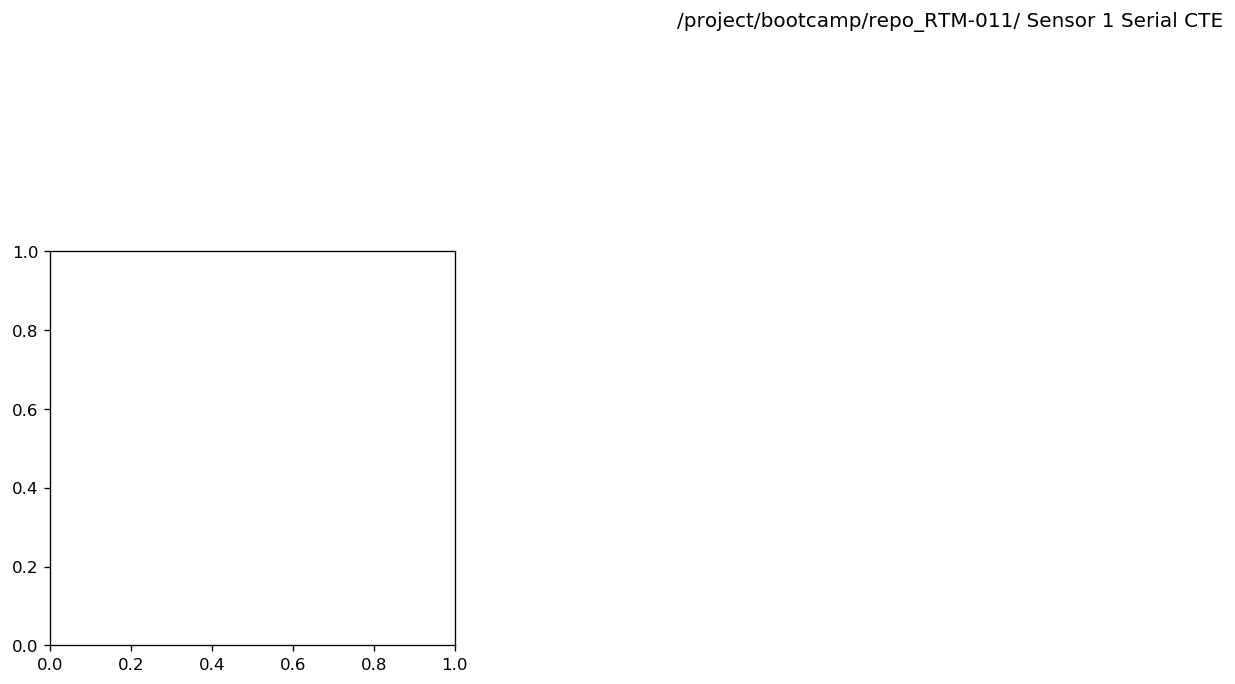

In [25]:
# what we need is the number of shift = nb_pre_scan+nb_image serial pixels 
nb_serial_shift=detector['C01'].getRawBBox().getDimensions().getX()-detector['C01'].getRawHorizontalOverscanBBox().getDimensions().getX()
y_good=5e-6
# 
for det_id in range(0,9):
    fig=plt.figure(figsize=(20,20))
    label='%s Sensor %d Serial CTE' % (BOOTCAMP_REPO_DIR,det_id)
    fig.suptitle(label)
    iplt=0
    for key in flipXY:
        iplt+=1
        ax=fig.add_subplot(4,4,iplt)
        flux=np.zeros((len(visits)))
        cti=np.zeros((len(visits)))
        cti_std=np.zeros((len(visits)))
        for i,visit in enumerate(visits) :
            fcur=file[det_id][visit]
            flux[i]=fcur[key]['median_flux']
            # Cti is pxiel computed from 1st overscan pixel + 2nd overscan pixel
            if fcur[key]['last_col'] == 0:
                cti[i] = 1
                cti_std[i] == 100
            else:
                cti[i]=(fcur[key]['serial'][0]+fcur[key]['serial'][1])/fcur[key]['last_col']/nb_serial_shift 
                cti_std[i]=np.sqrt(fcur[key]['serial_std'][0]**2+fcur[key]['serial_std'][0]**2)/fcur[key]['last_col']/nb_serial_shift  
        plt.errorbar(flux,cti,yerr=cti_std,fmt='o',color='b', ecolor='b',label=key)
        xmin=min(flux)*.9
        xmax=max(flux)*1.1
        plt.plot([xmin,xmax],[y_good,y_good],'g')
        plt.xscale('symlog')
        plt.yscale('log')
        plt.ylim(1e-8,max(max(cti),y_good)*1.1)
        if iplt%4 ==0 :
            label= 'CTI for dev %d %s' % (det_id,key)
            plt.ylabel(label)
        if iplt>12 :
            plt.xlabel('Flux in ADU')
    plt.show()    

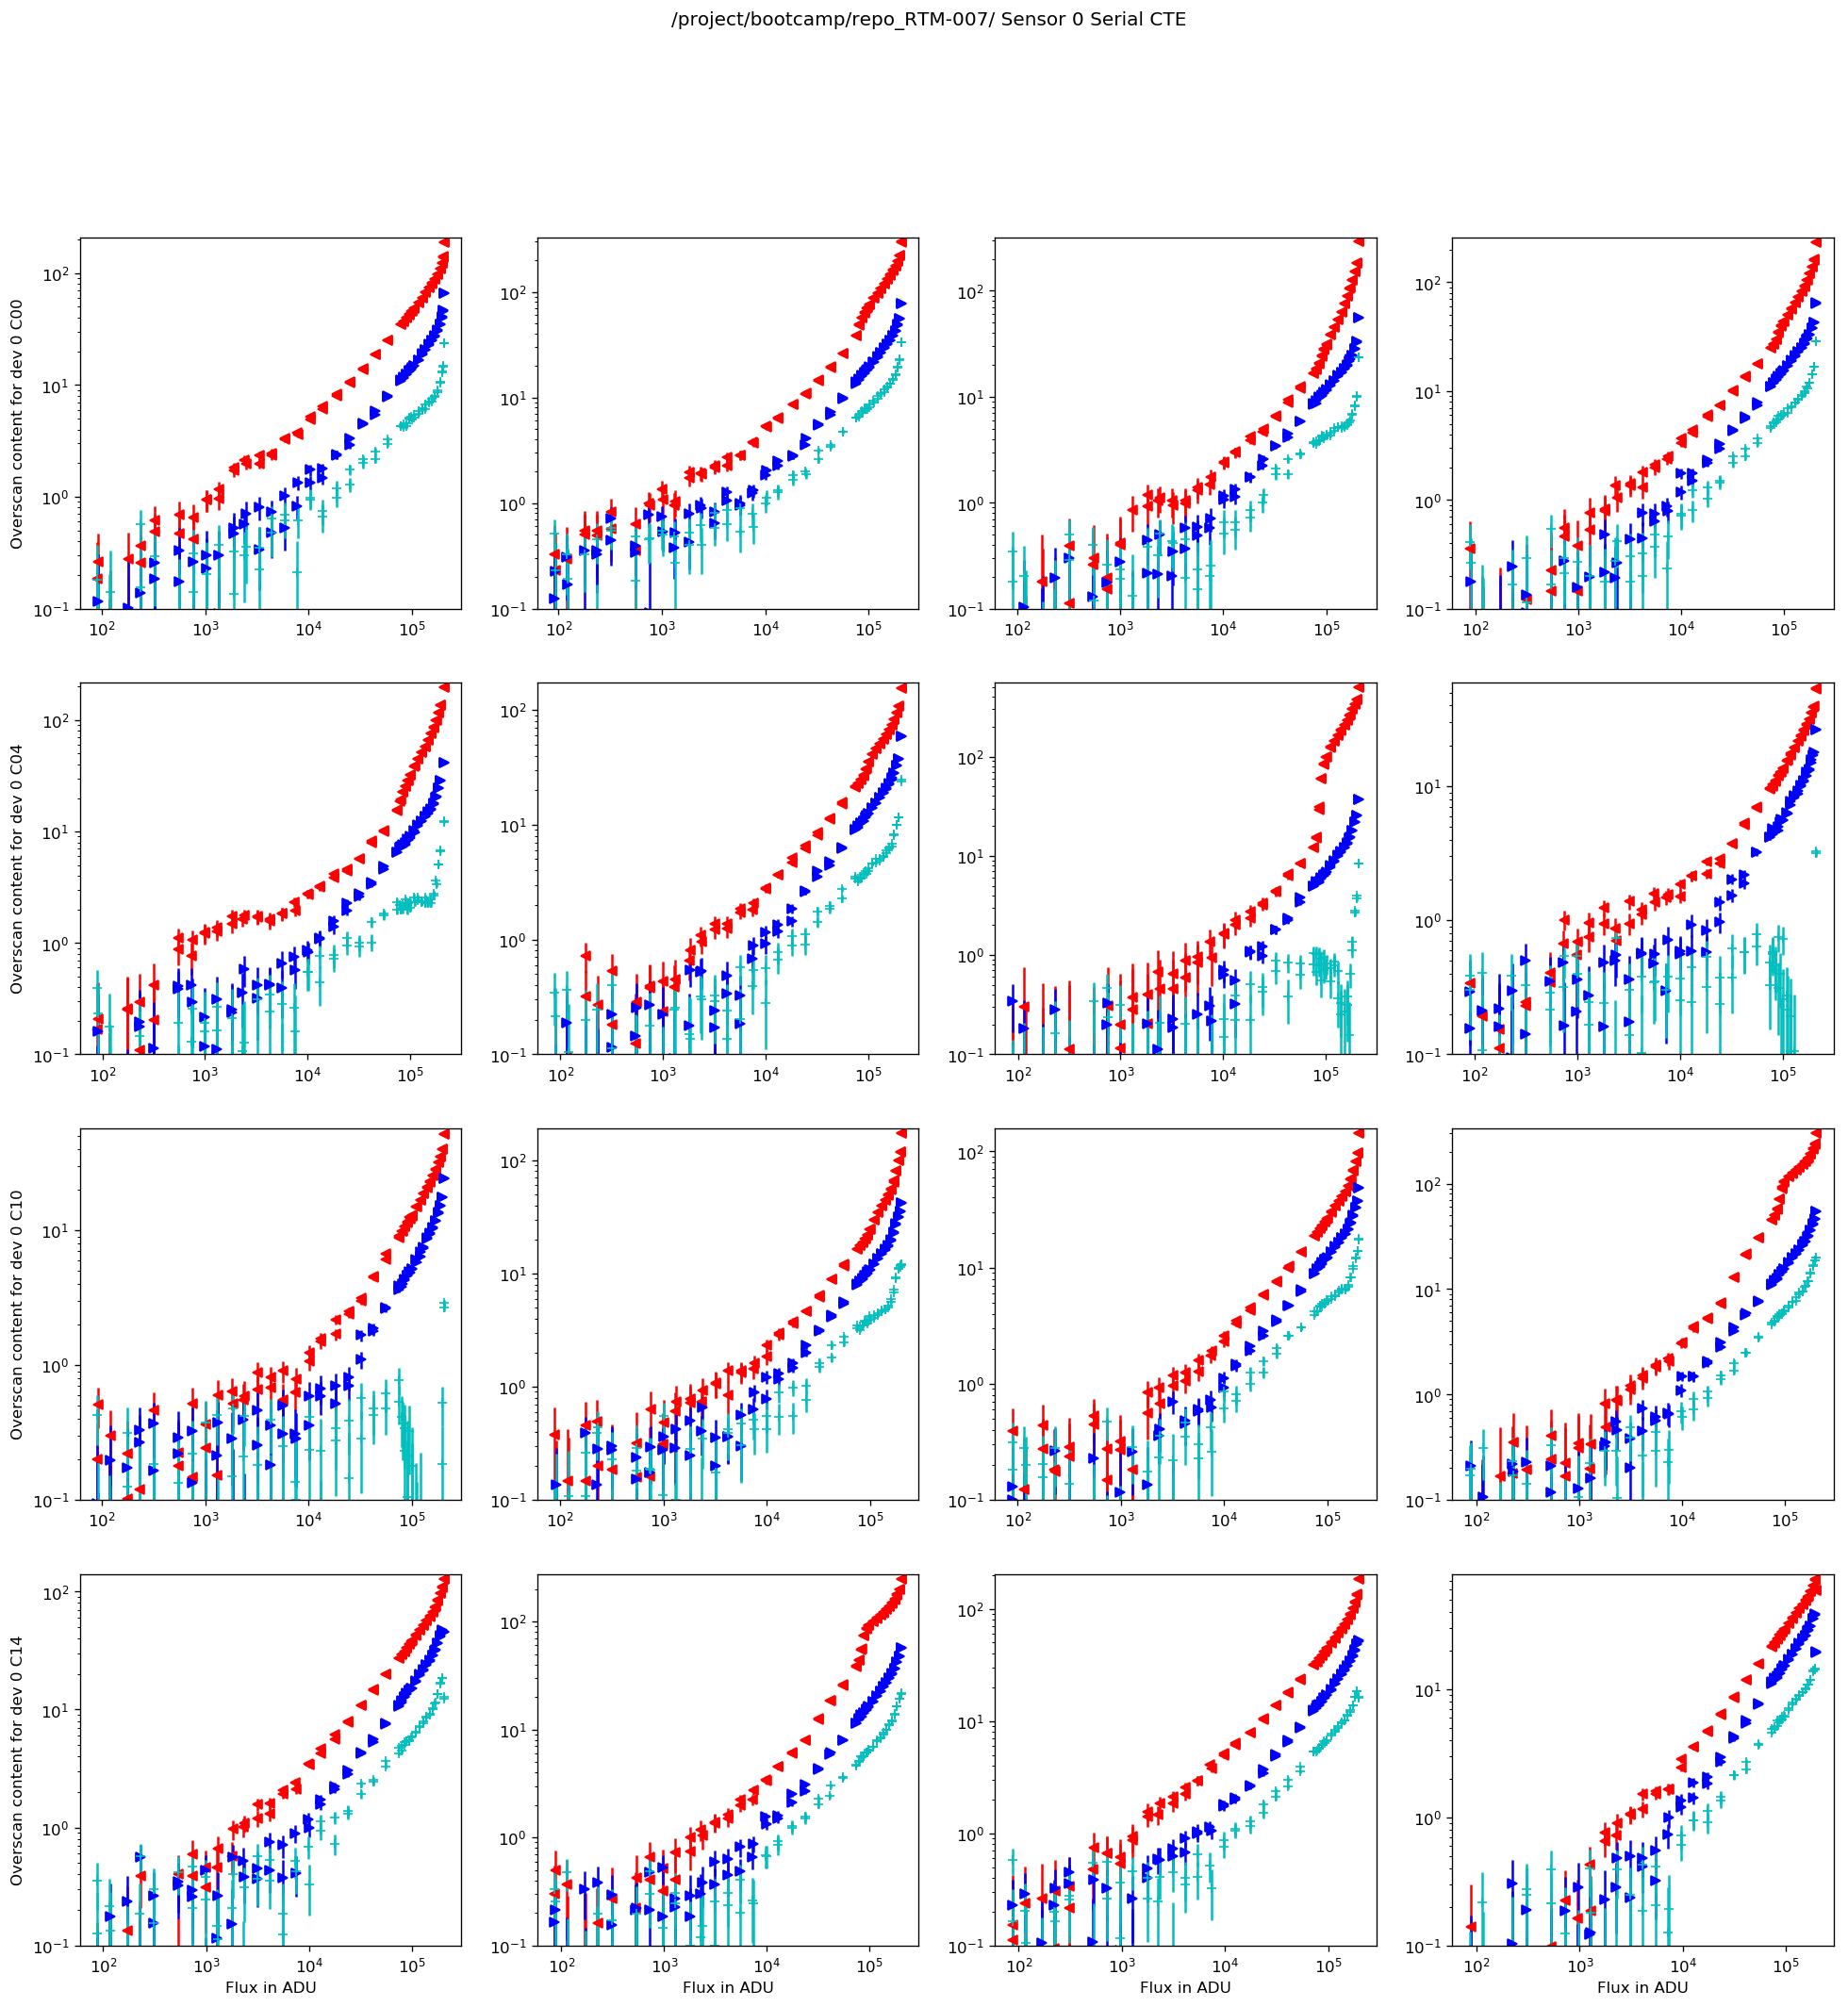

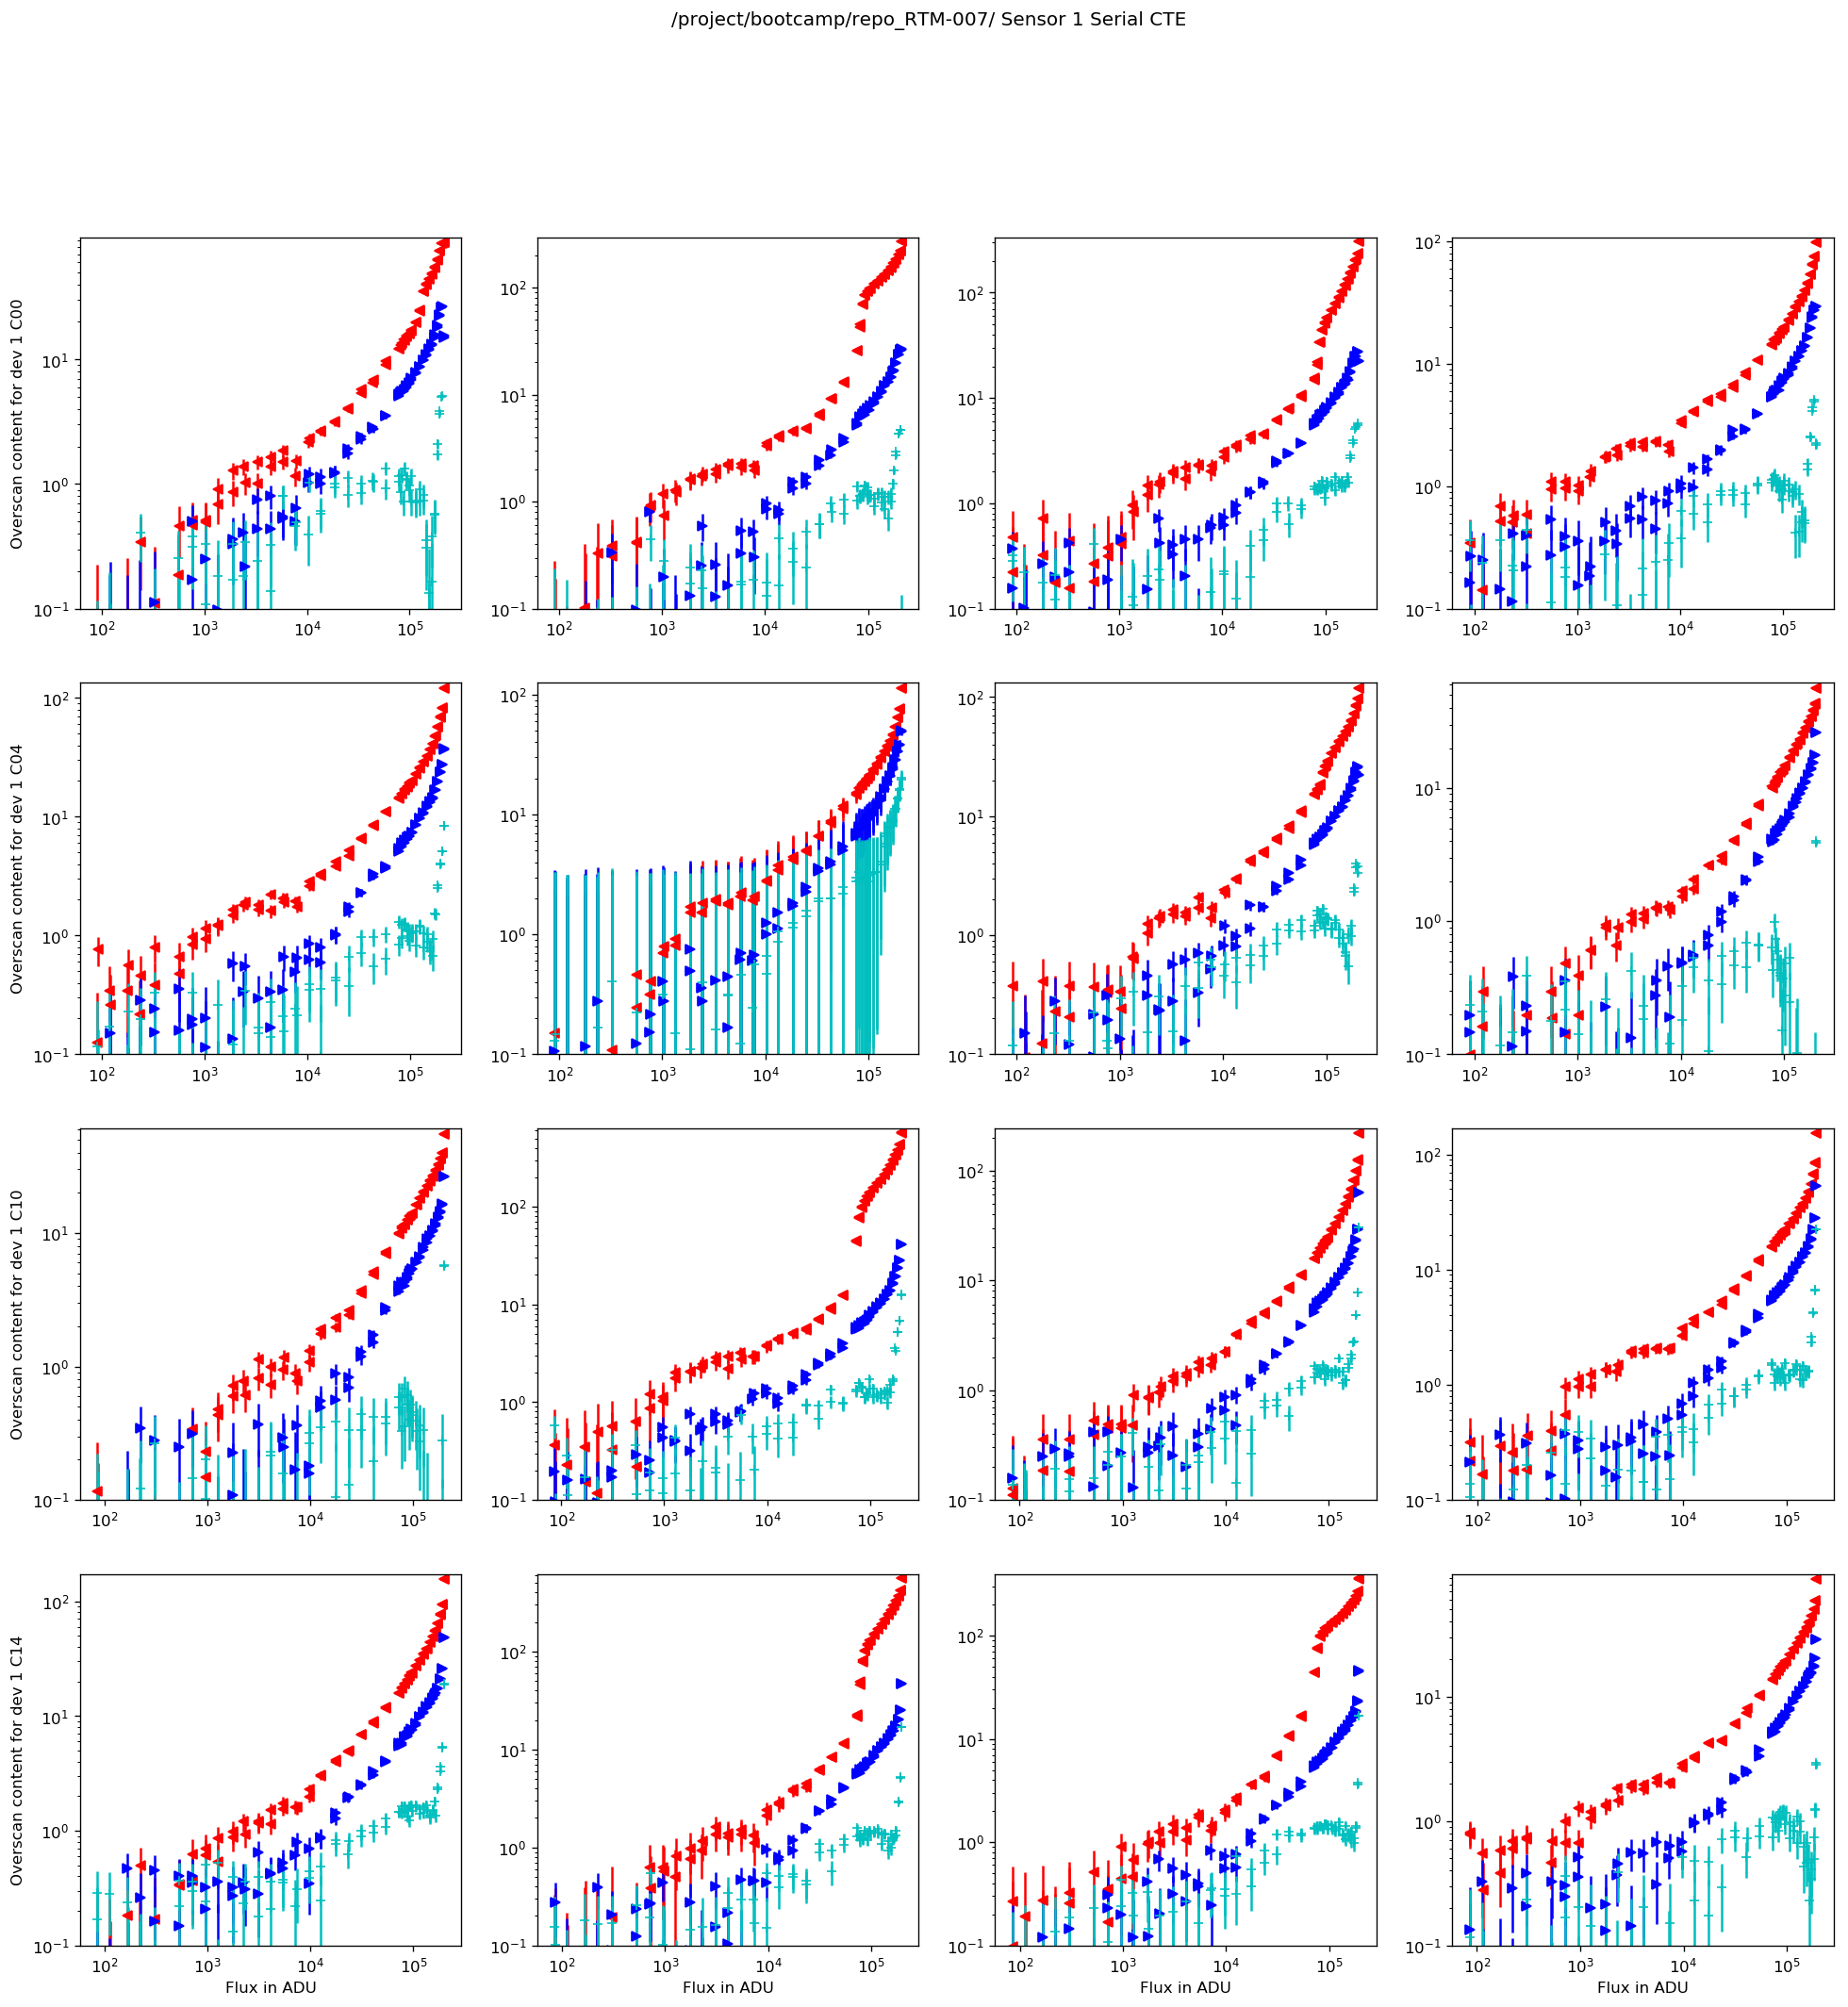

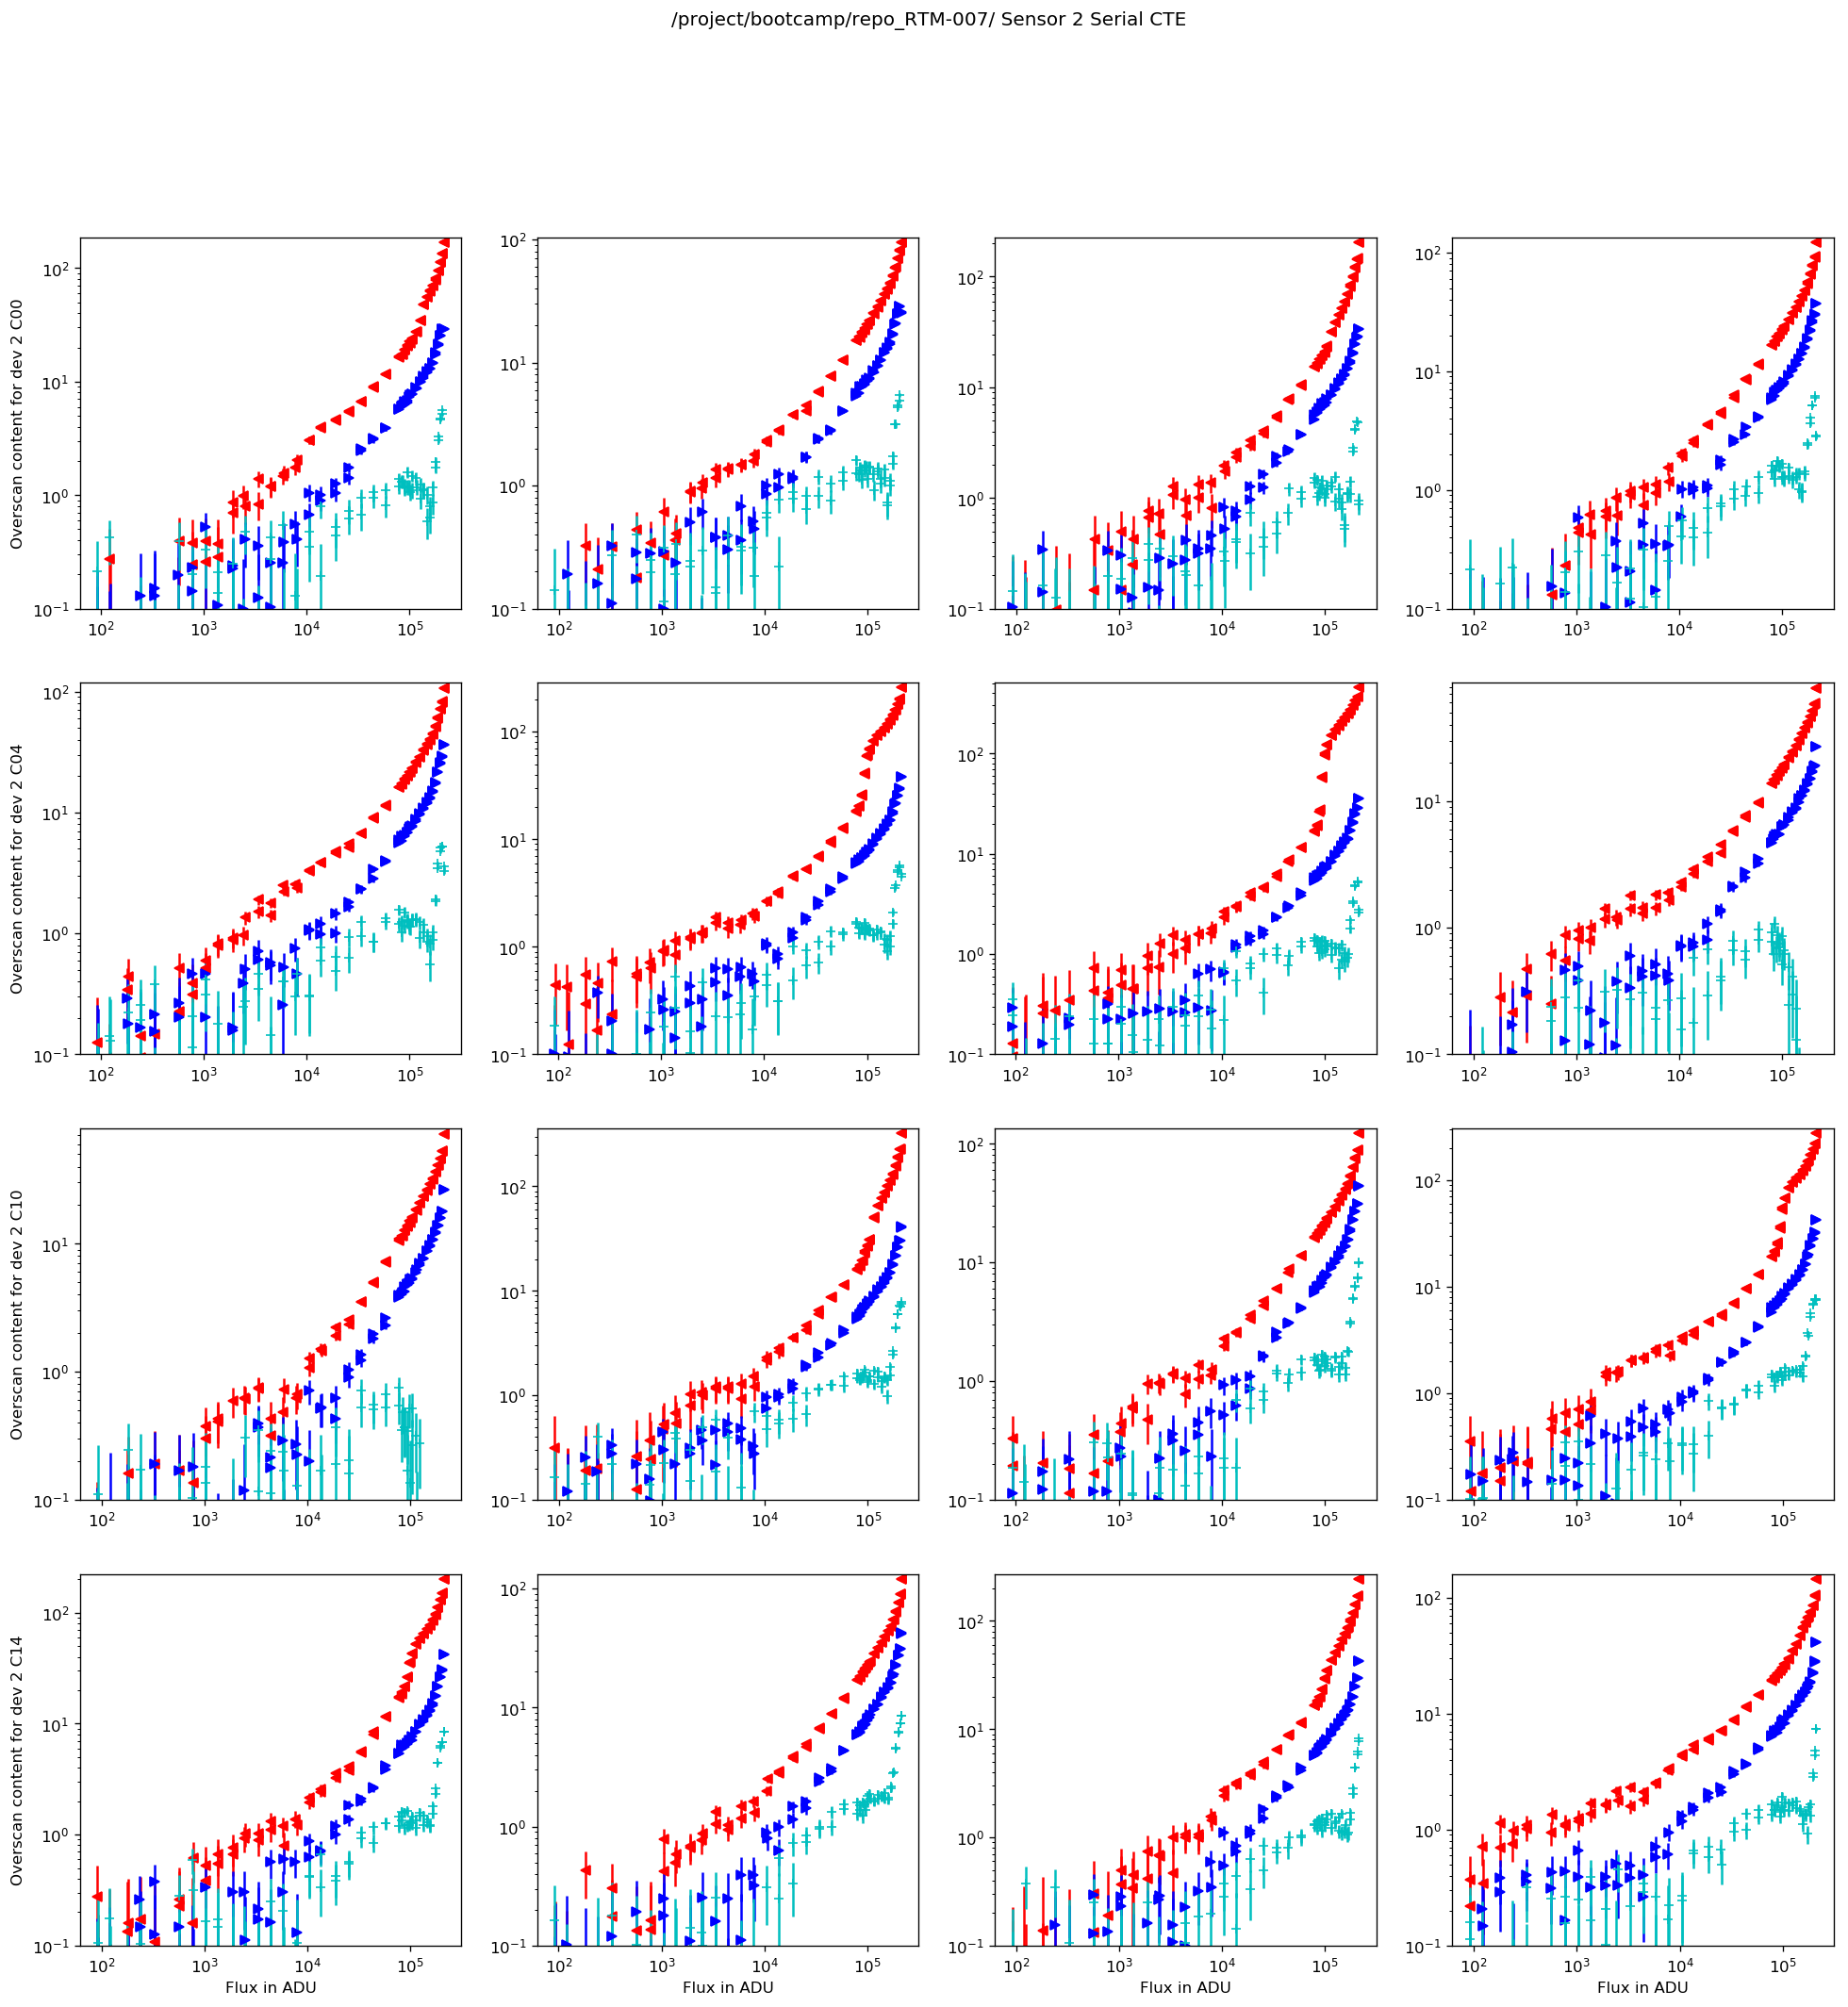

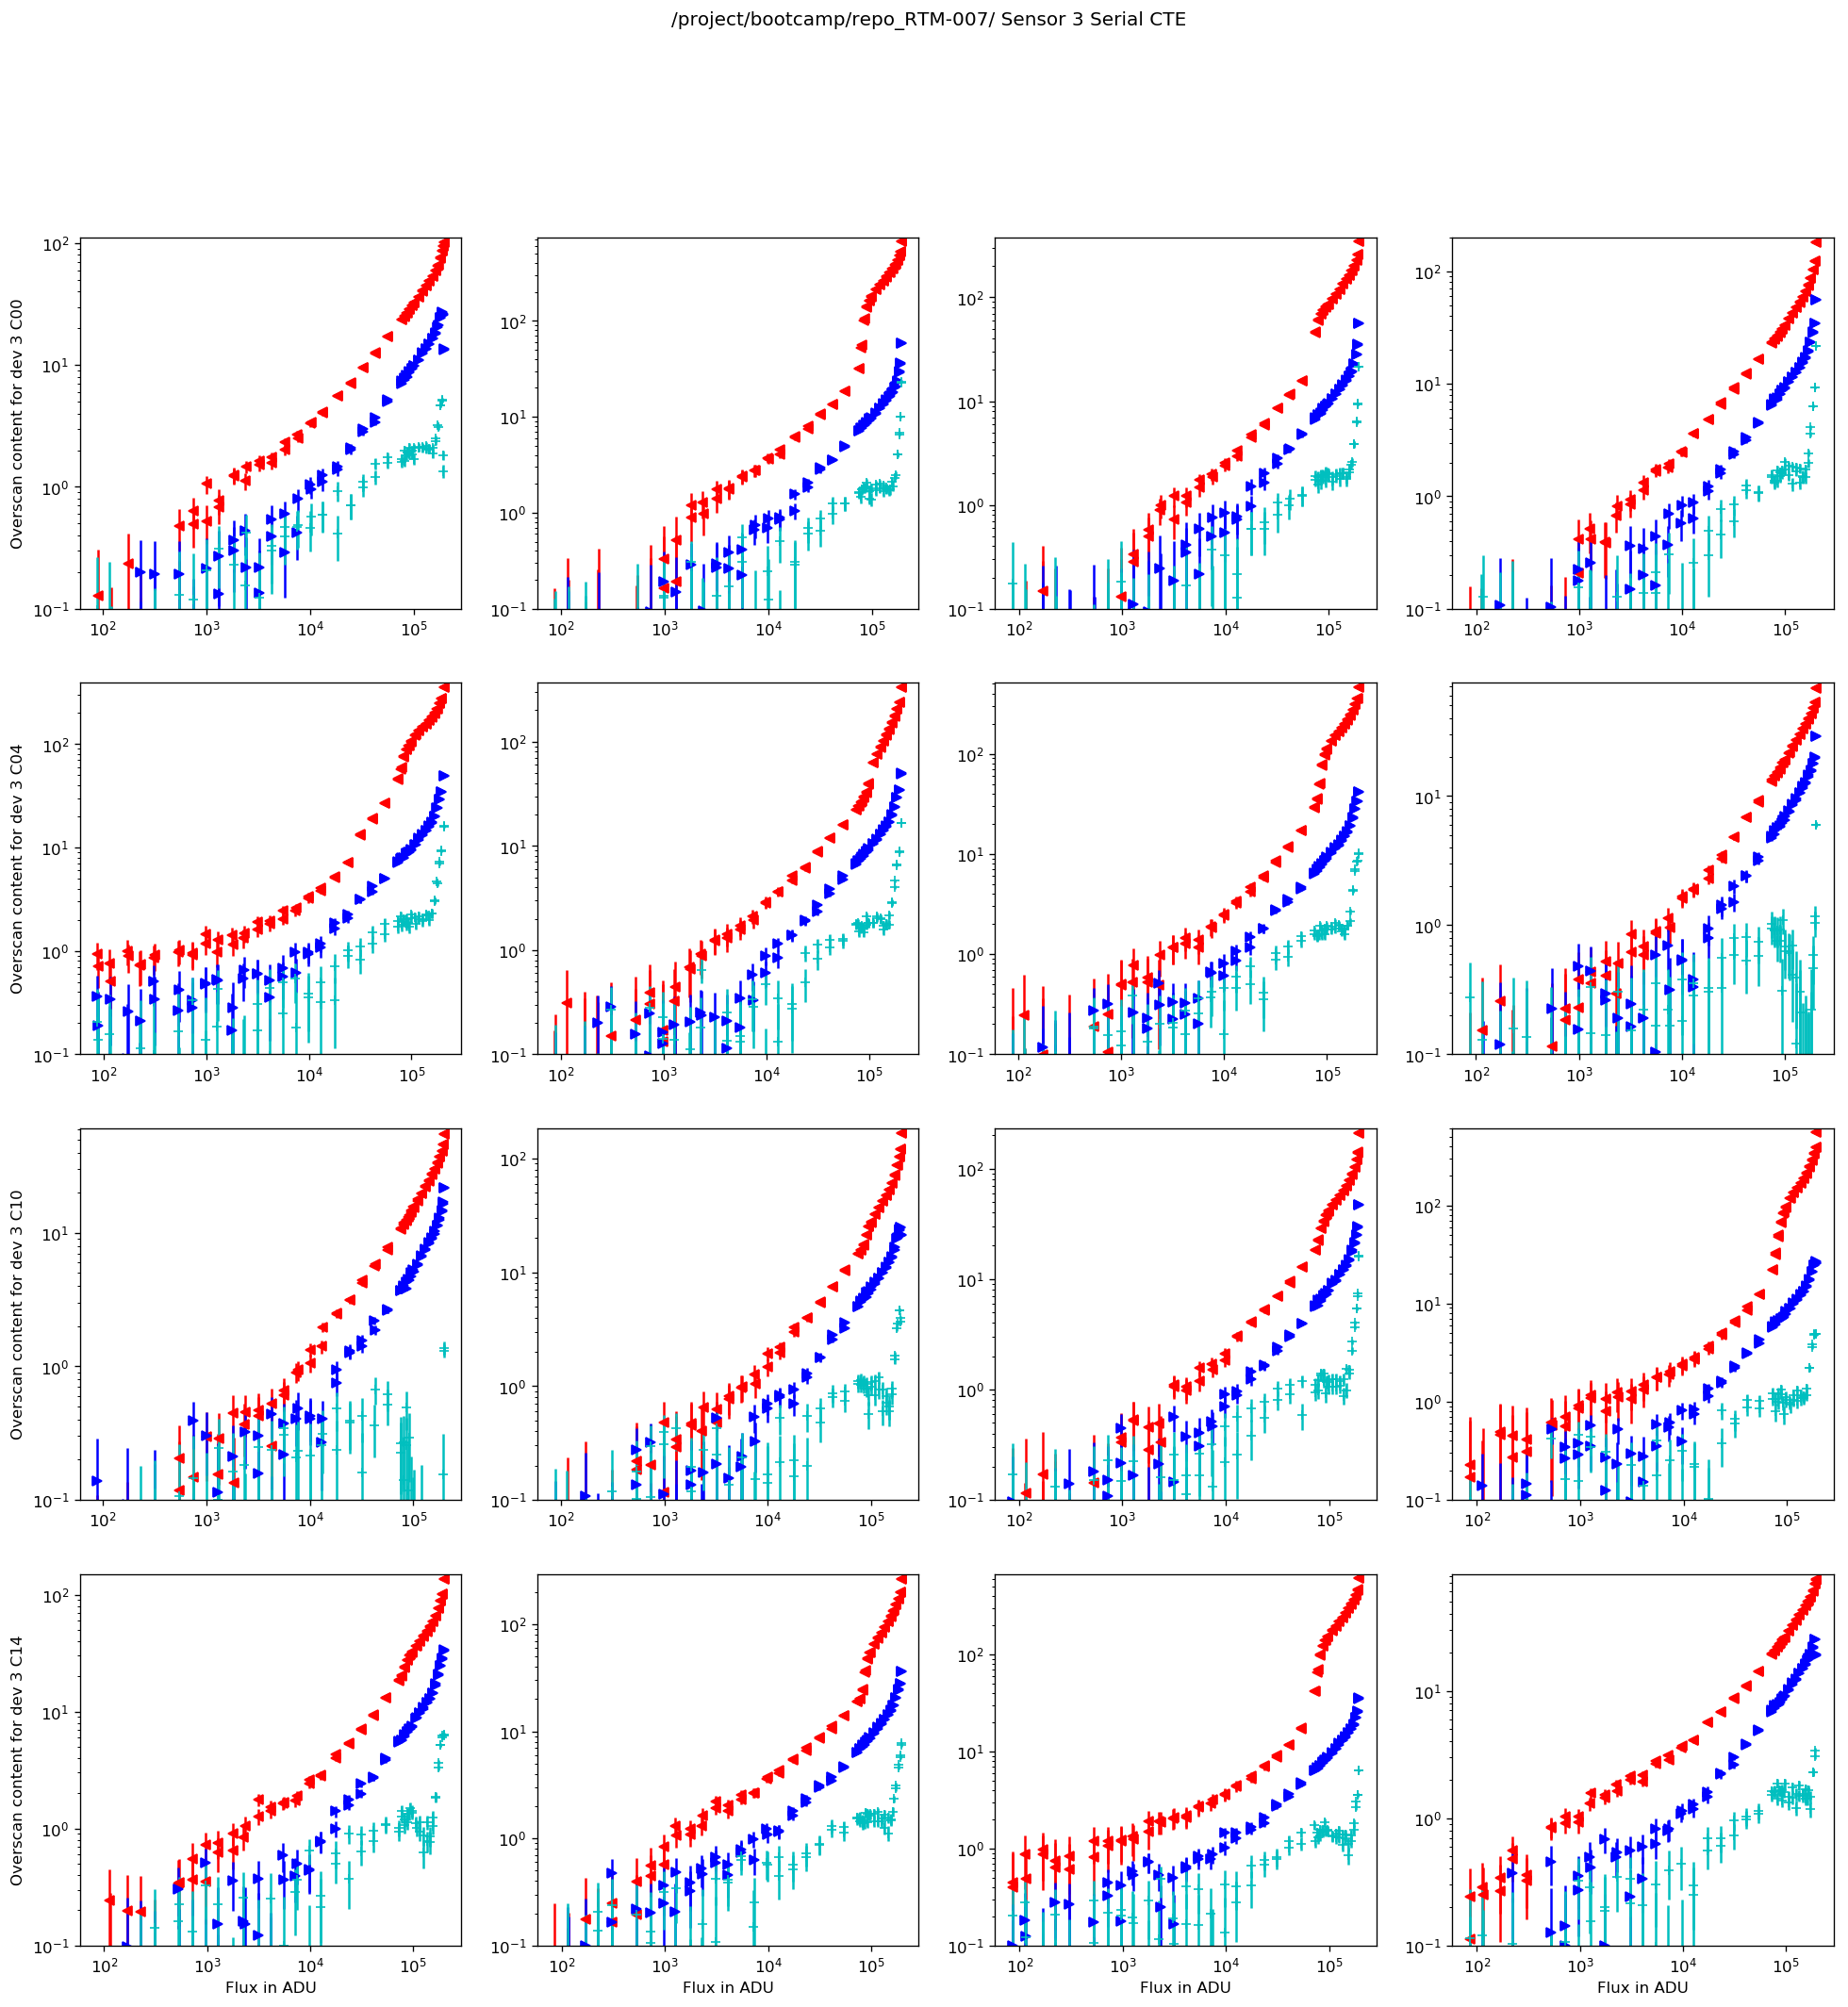

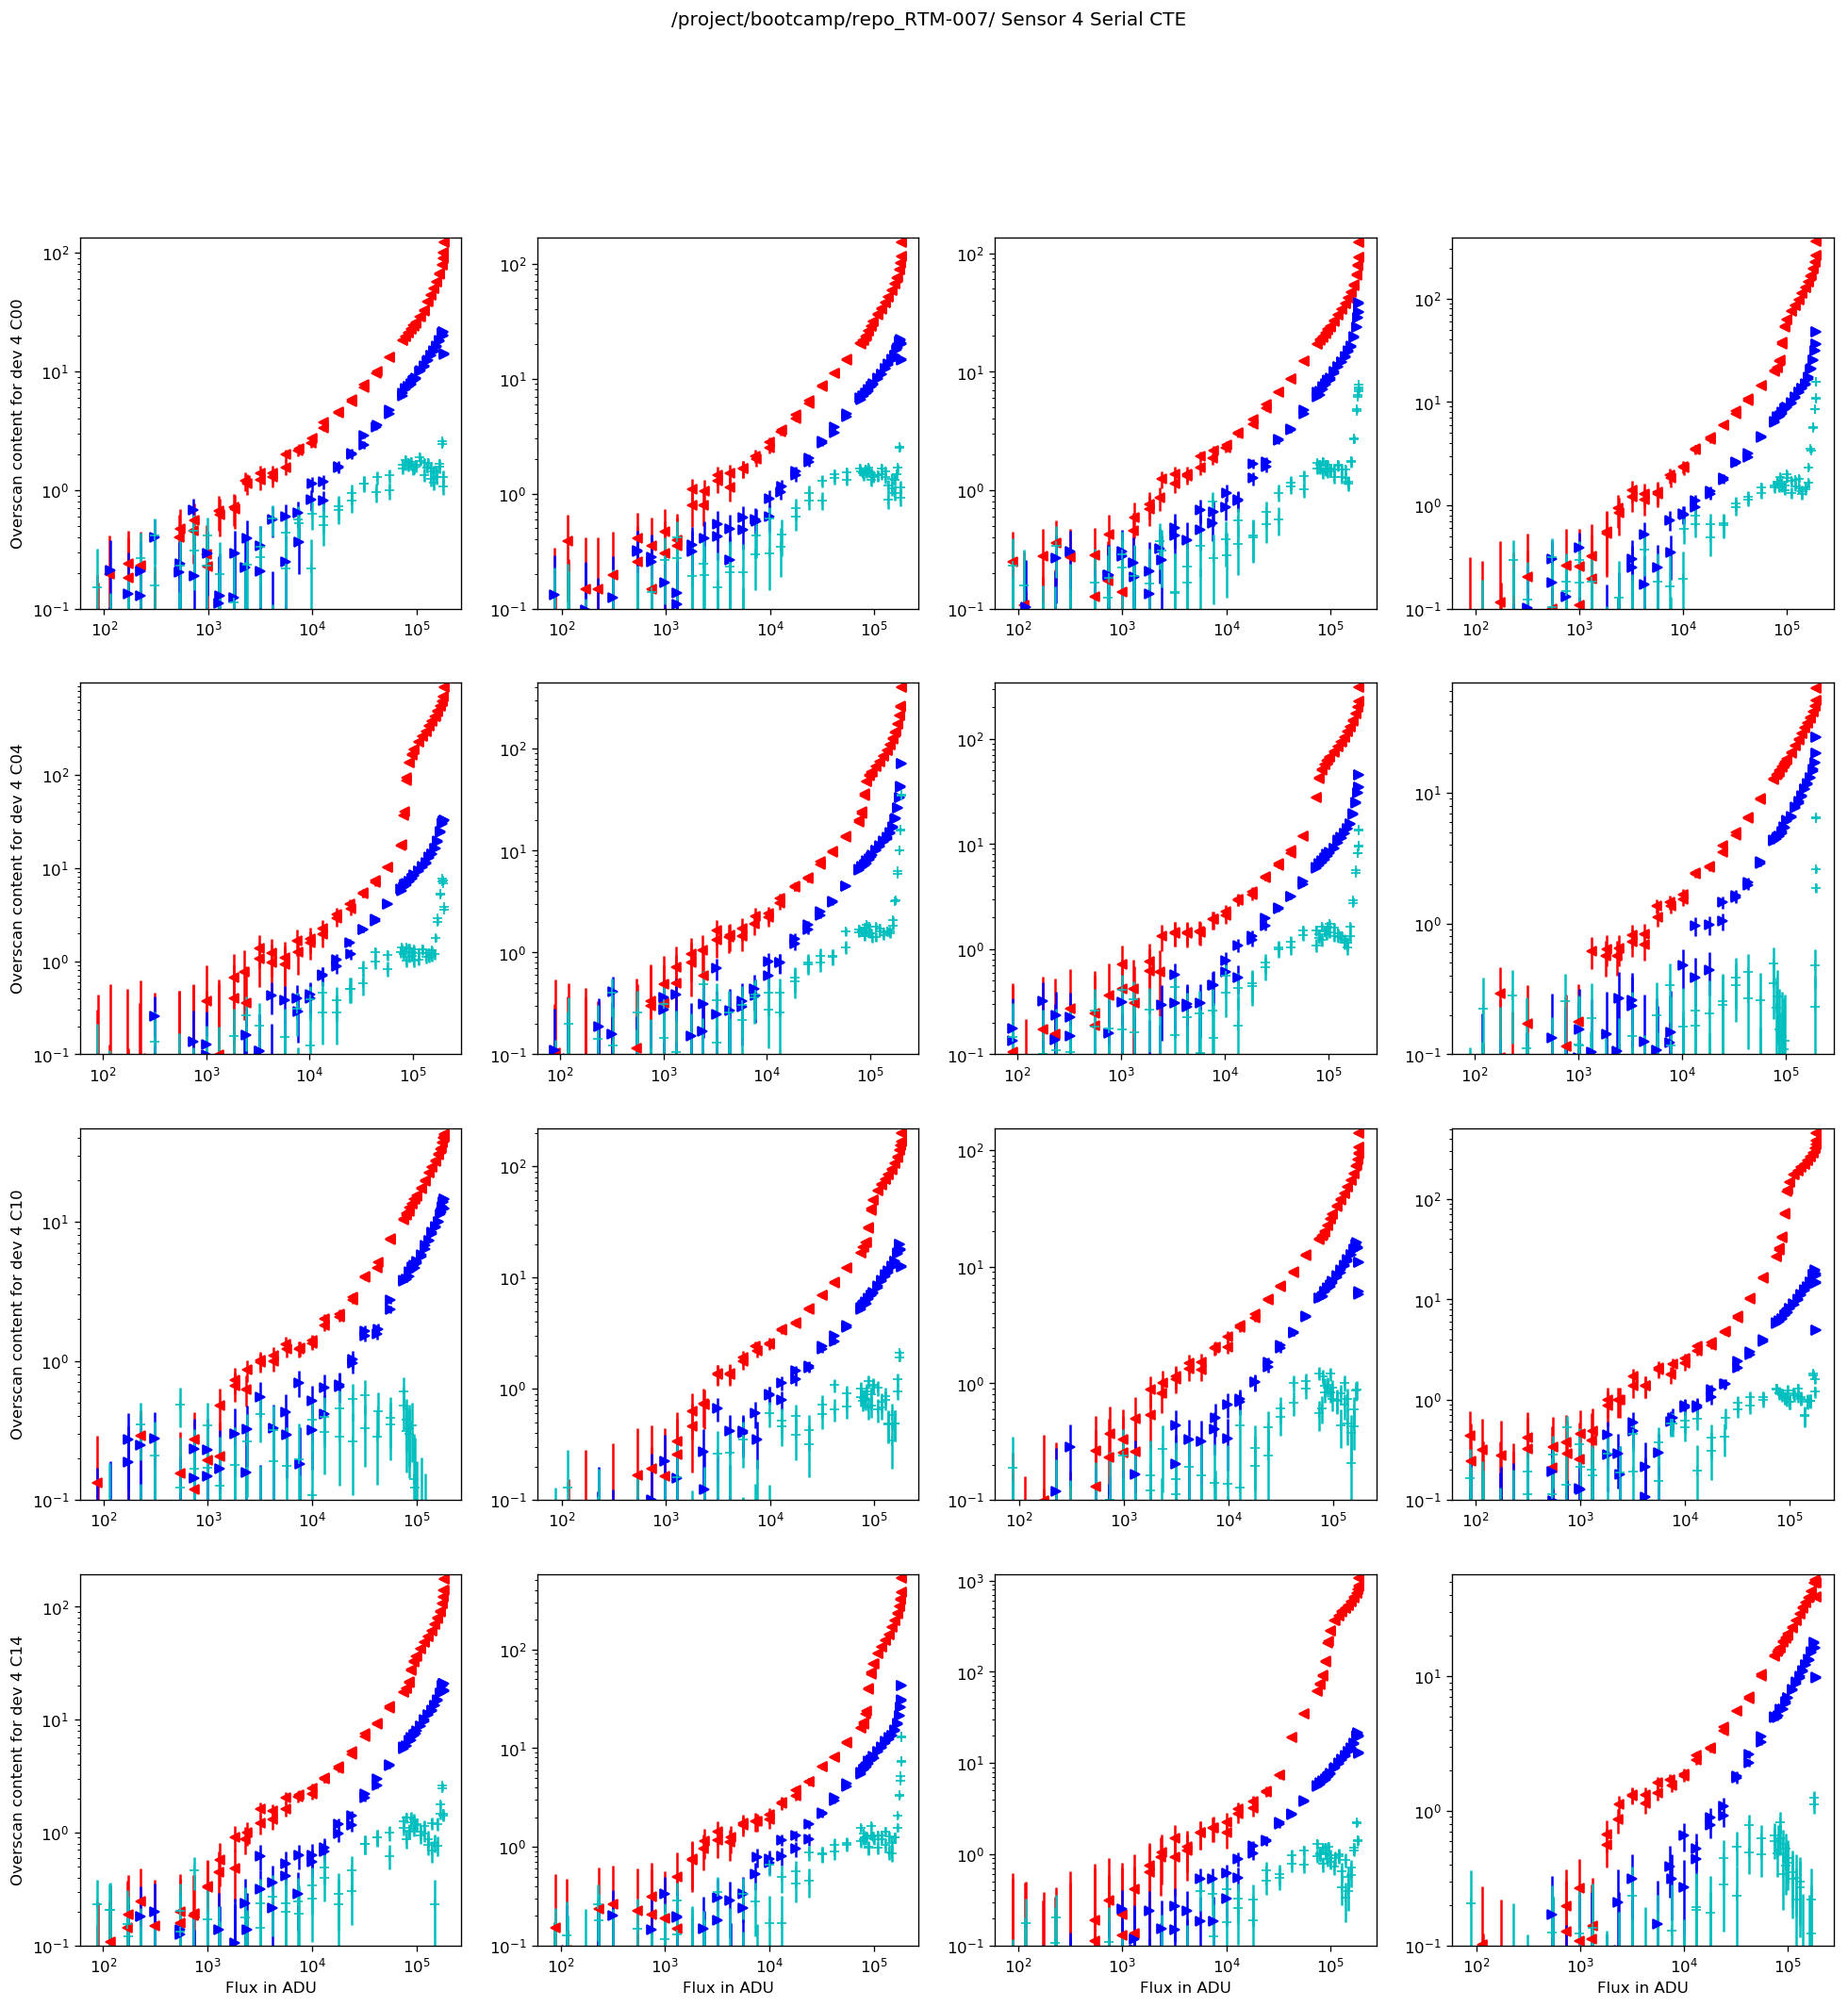

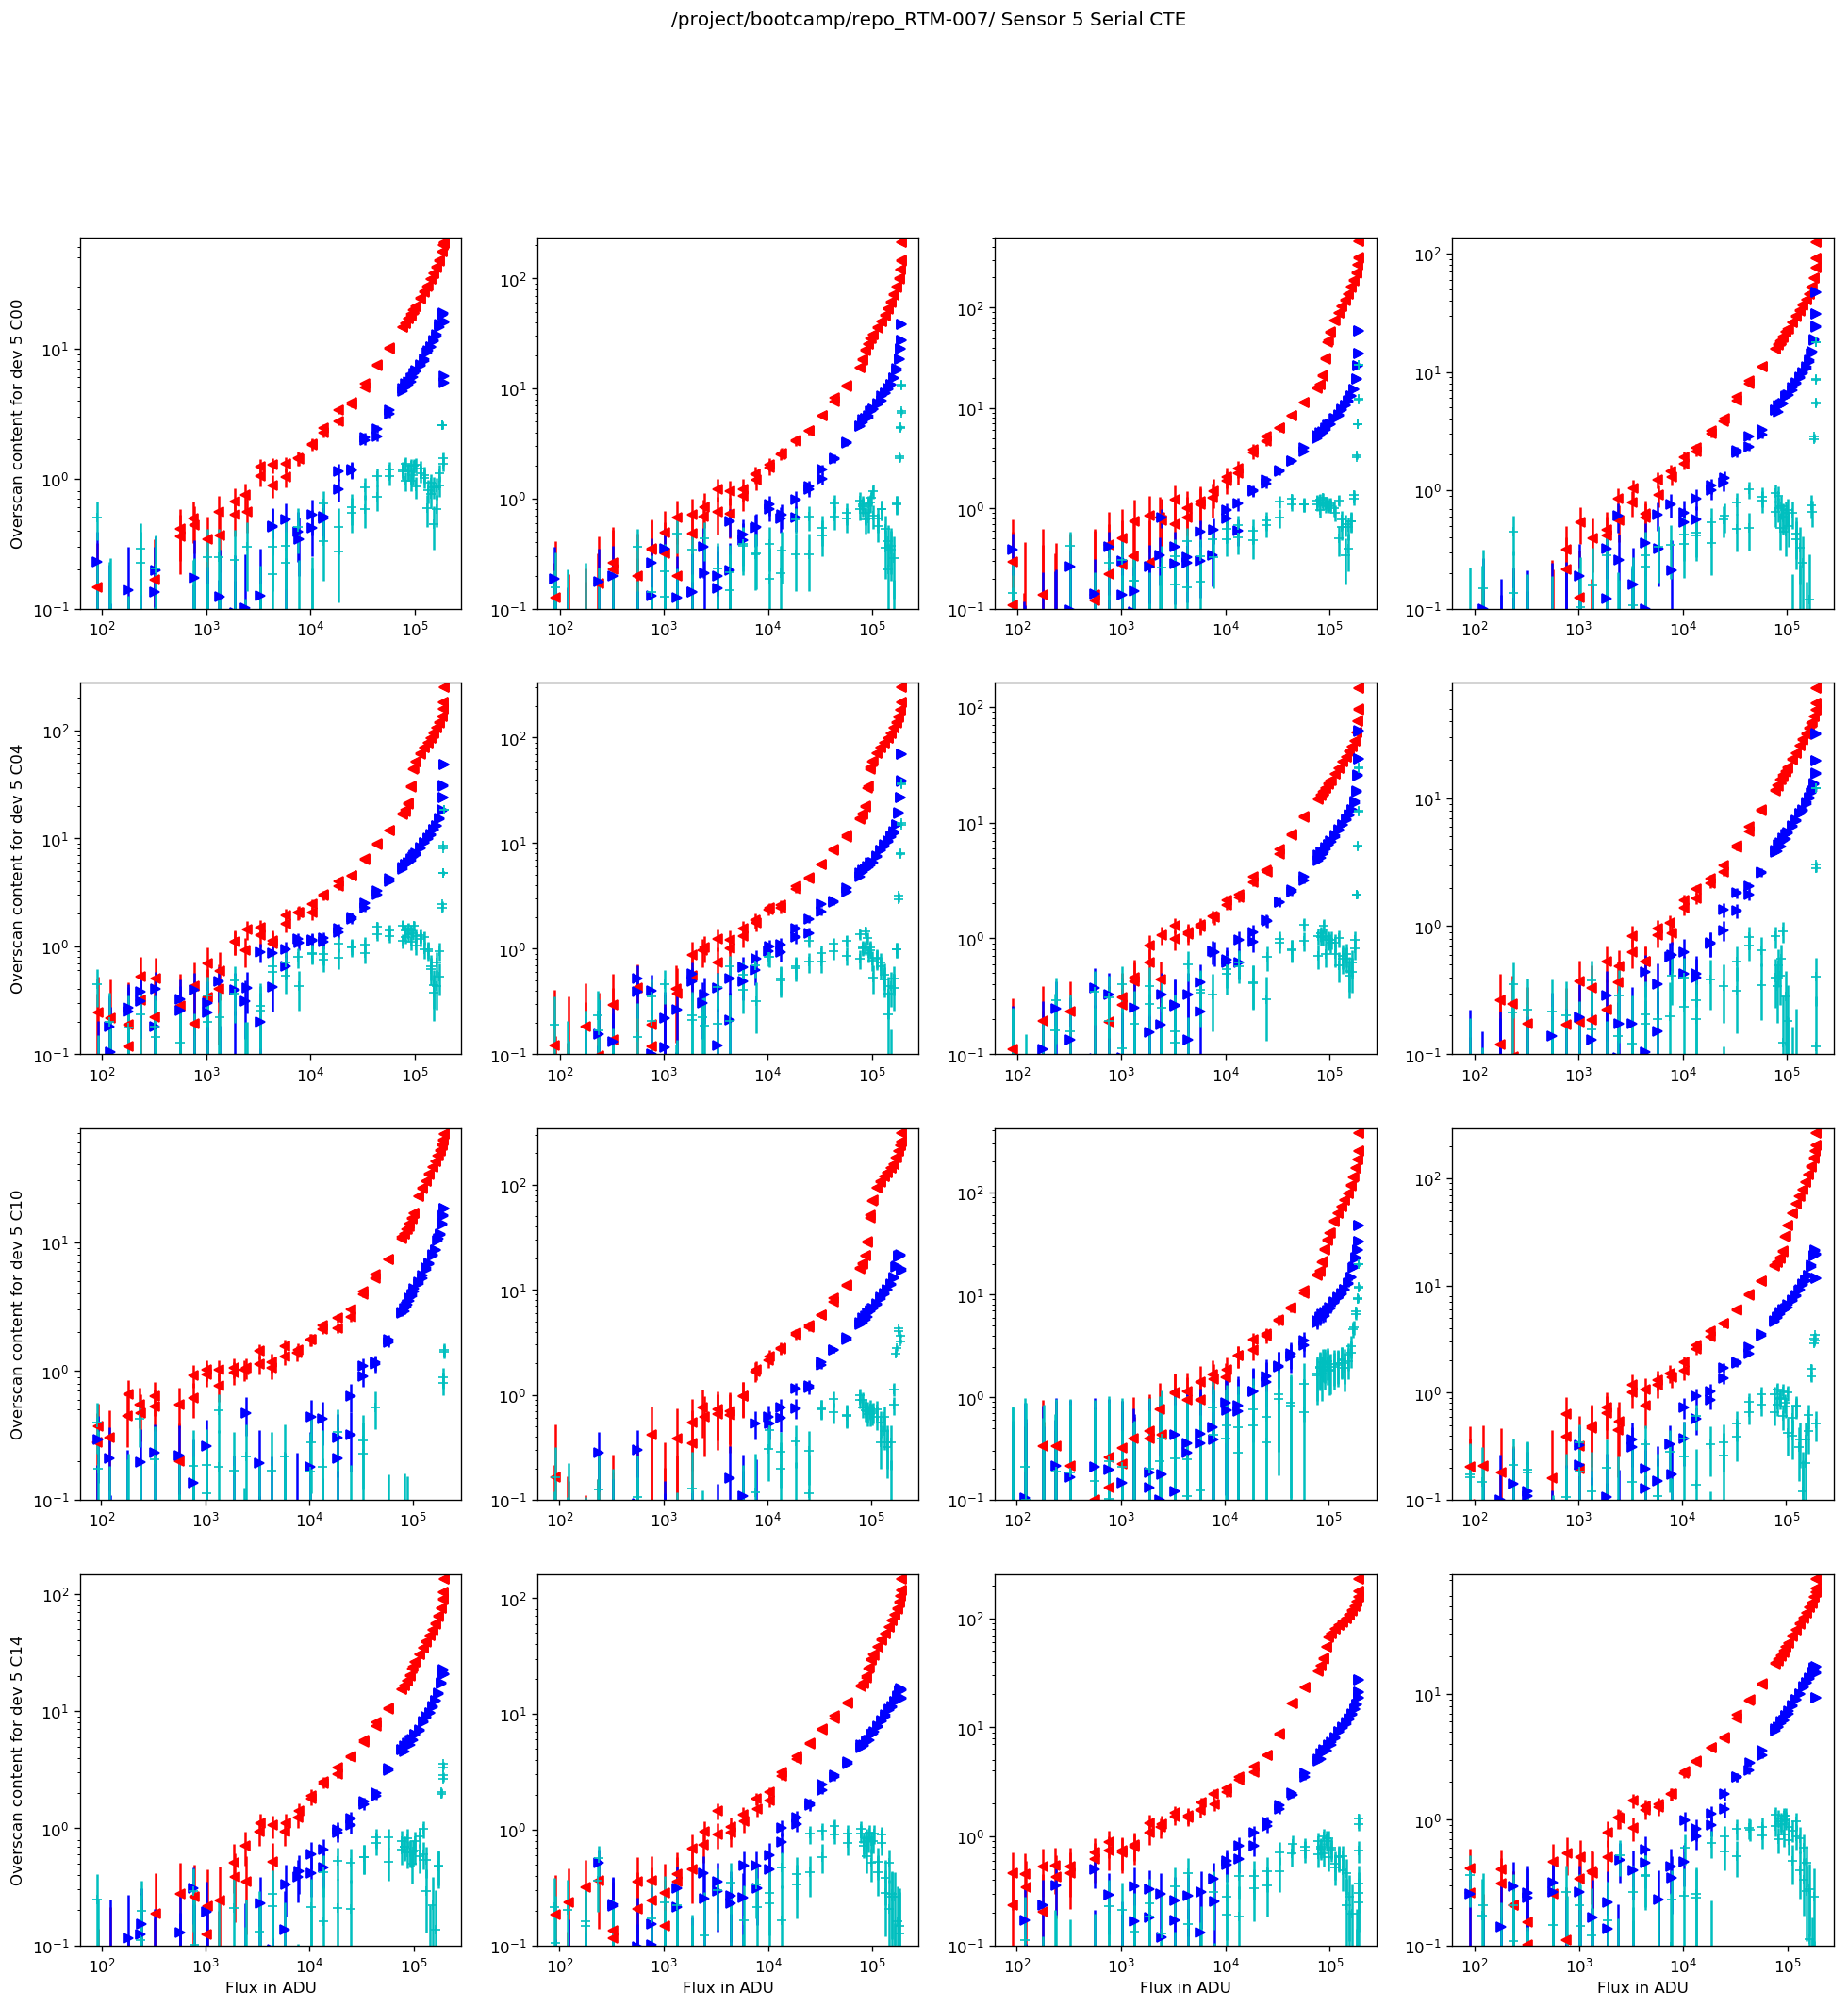

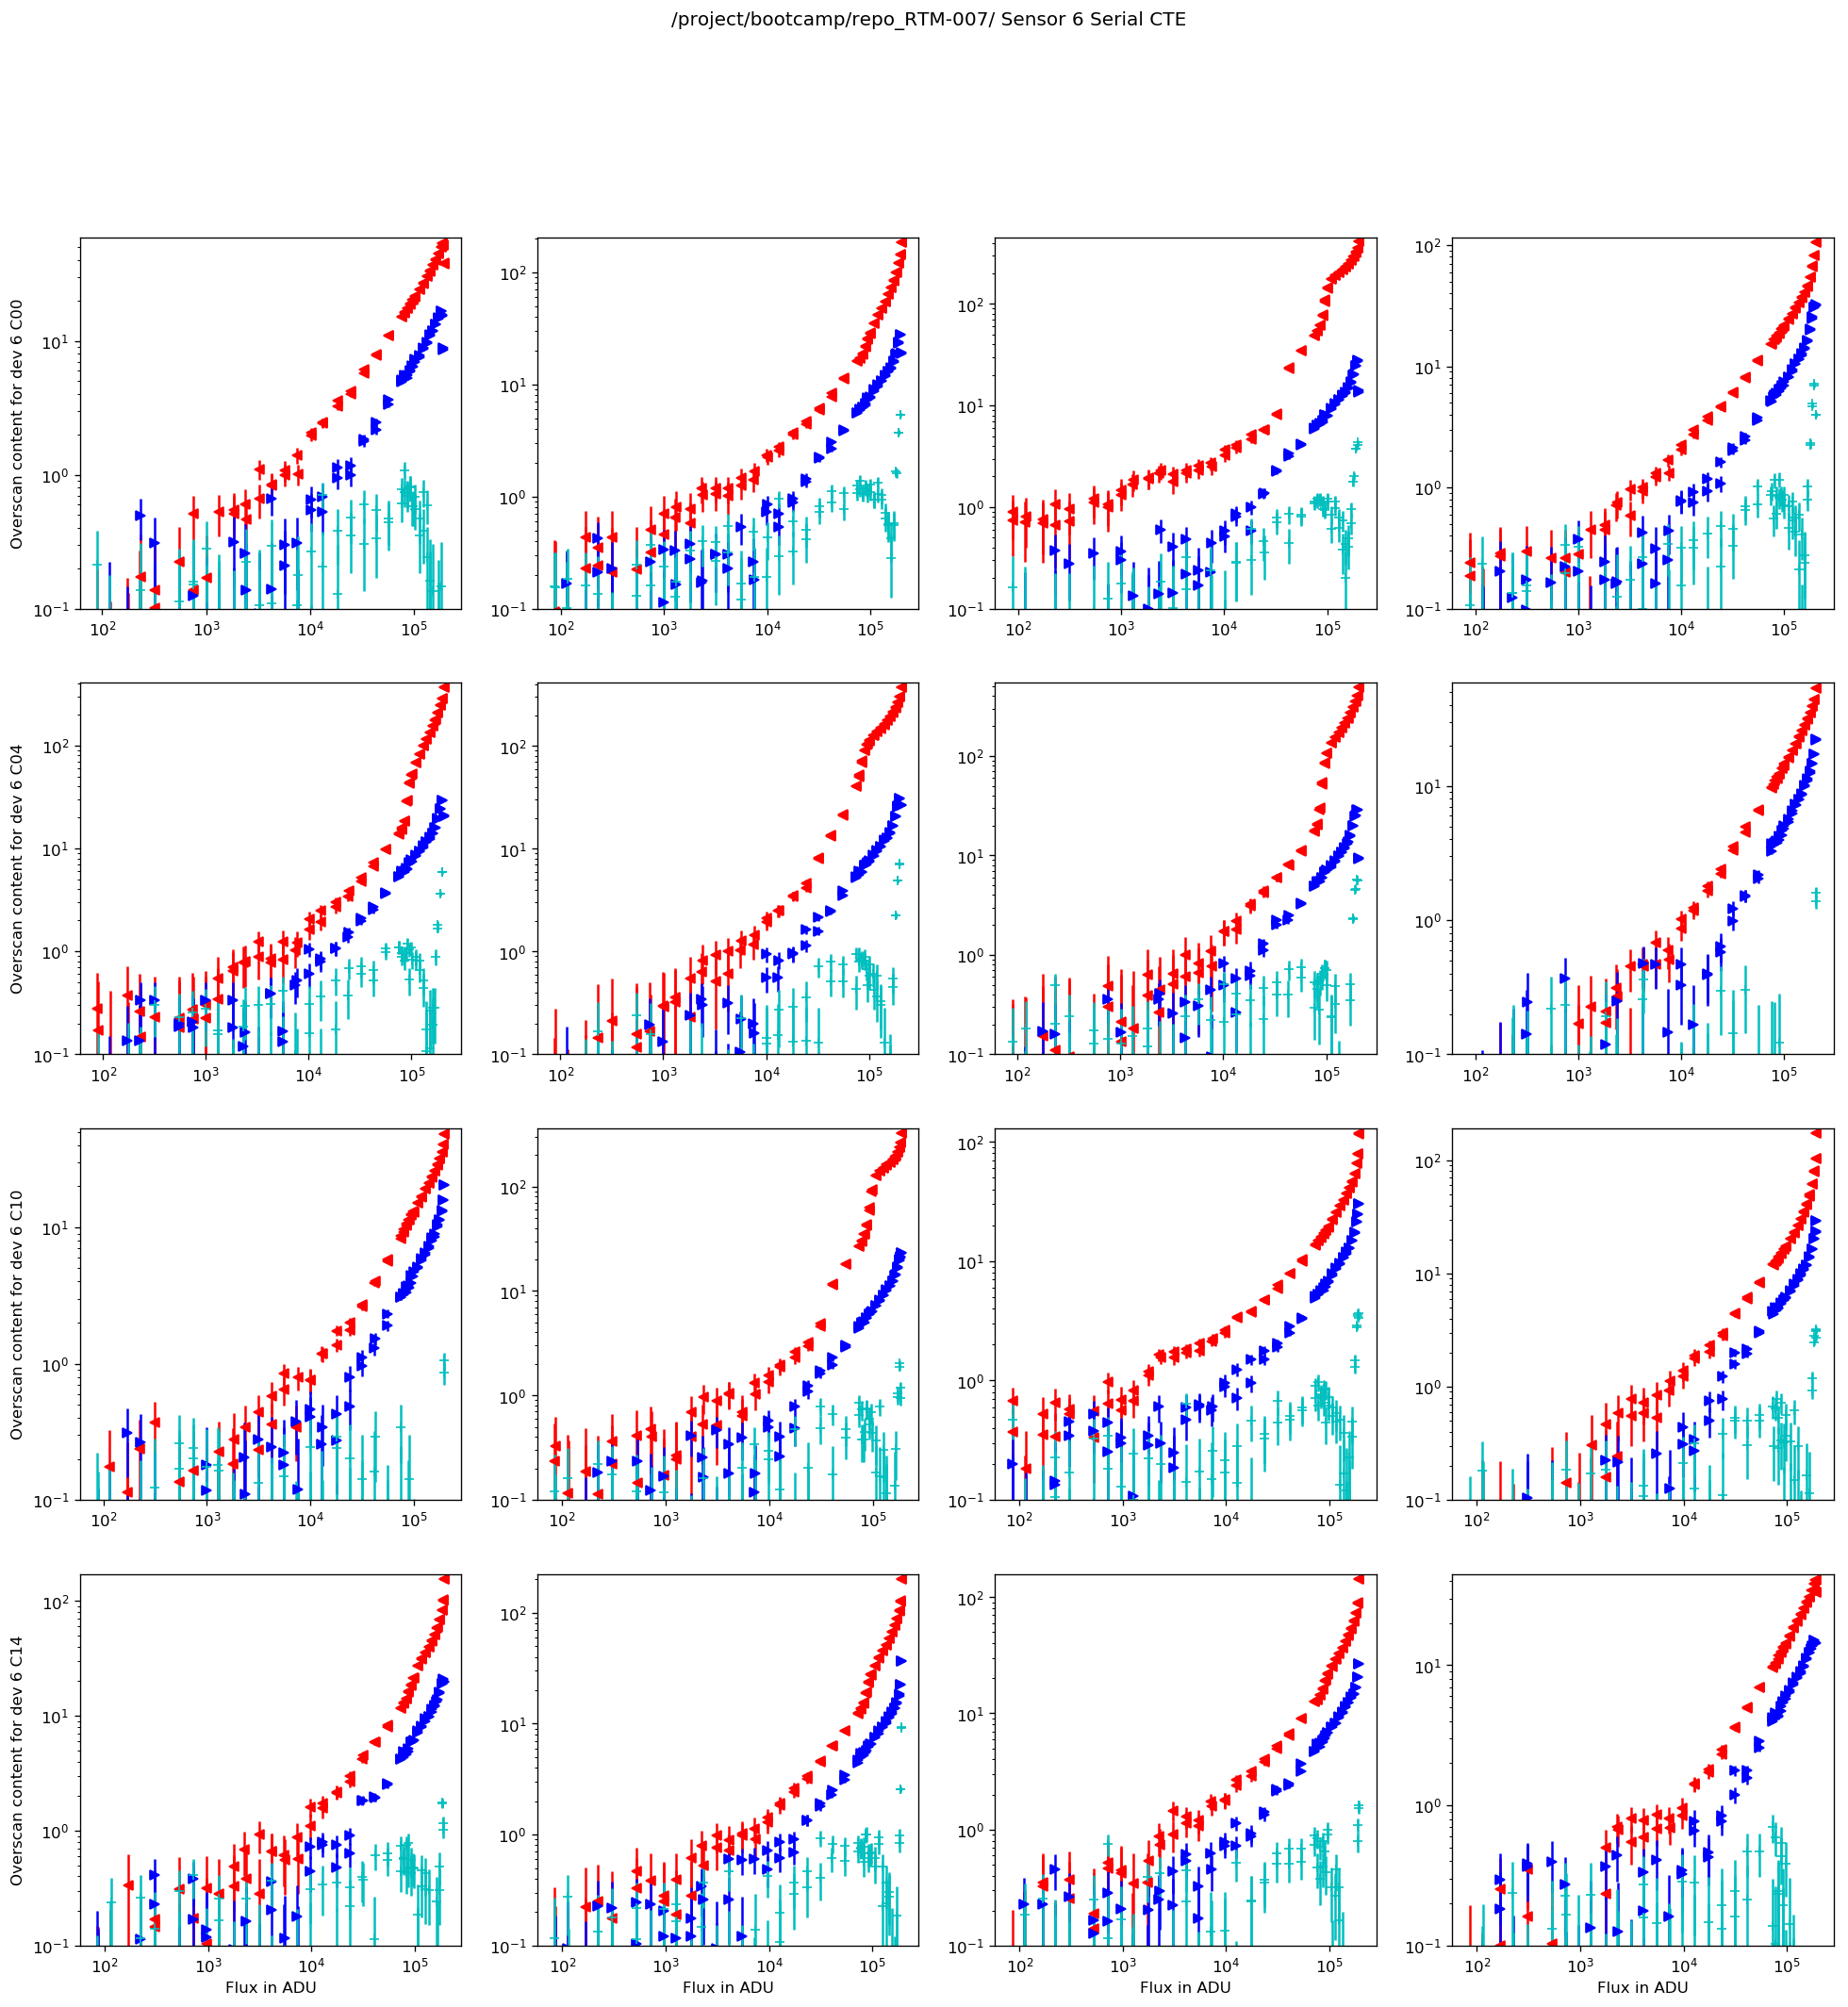

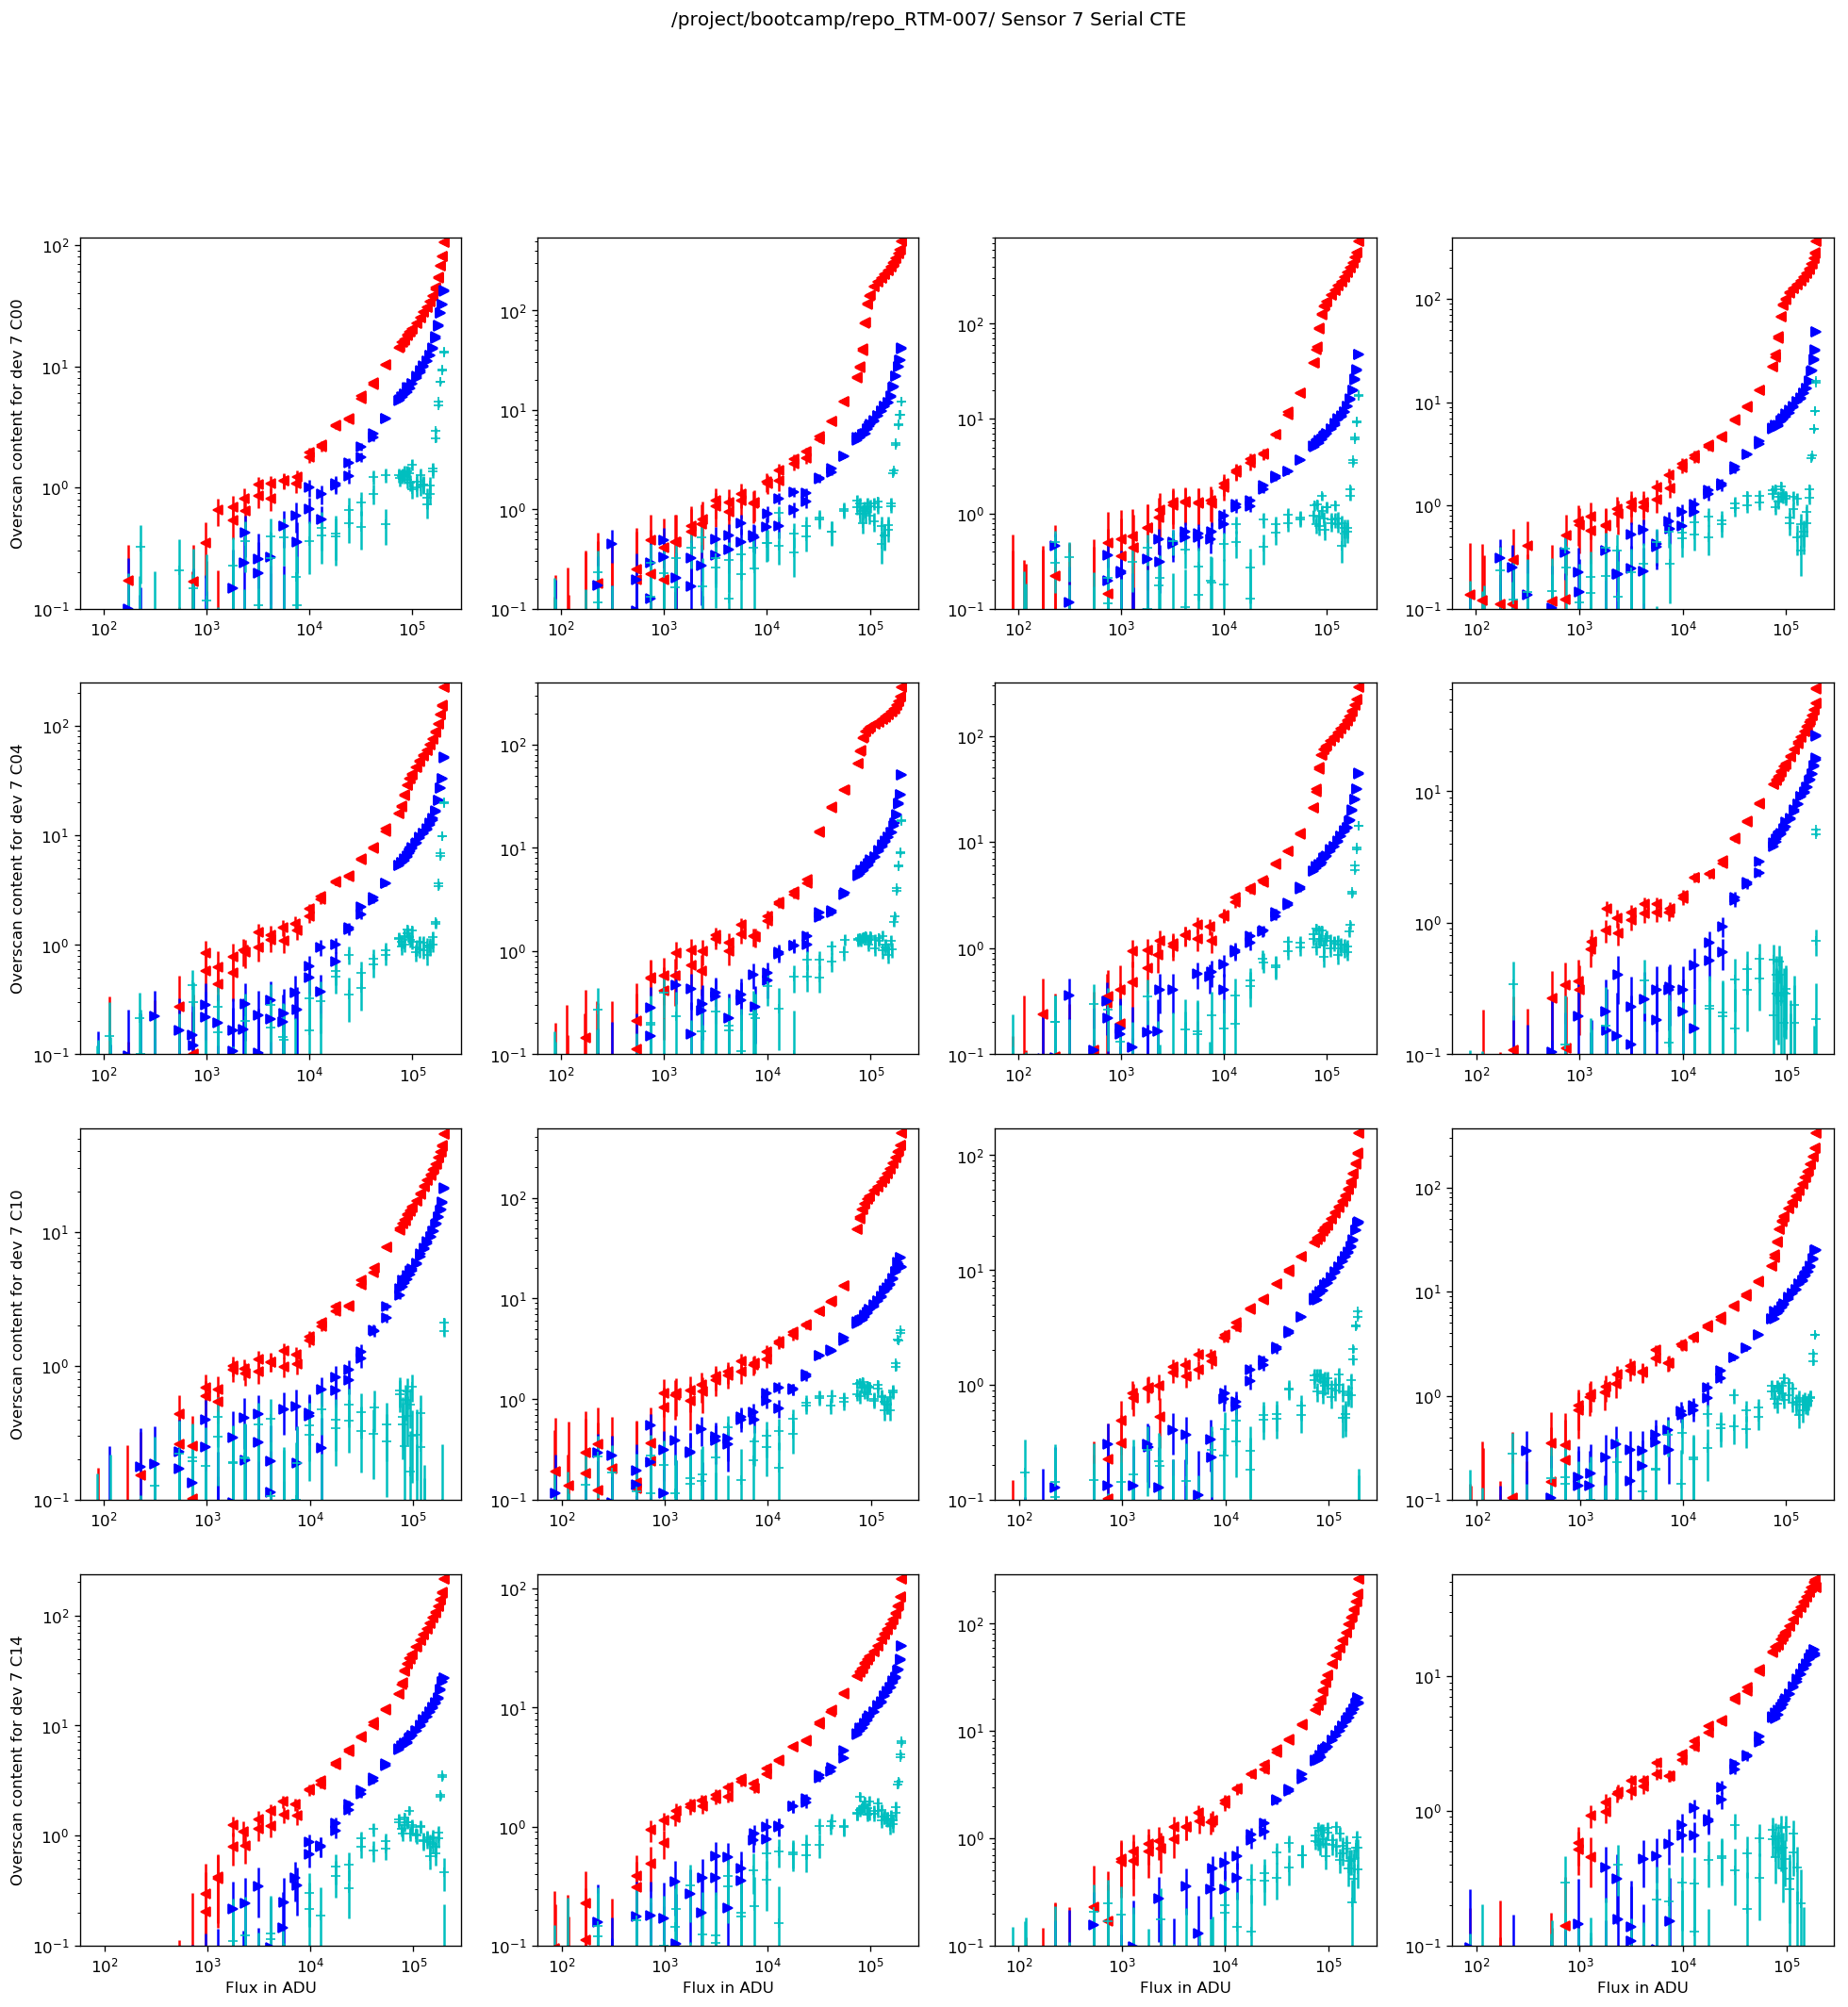

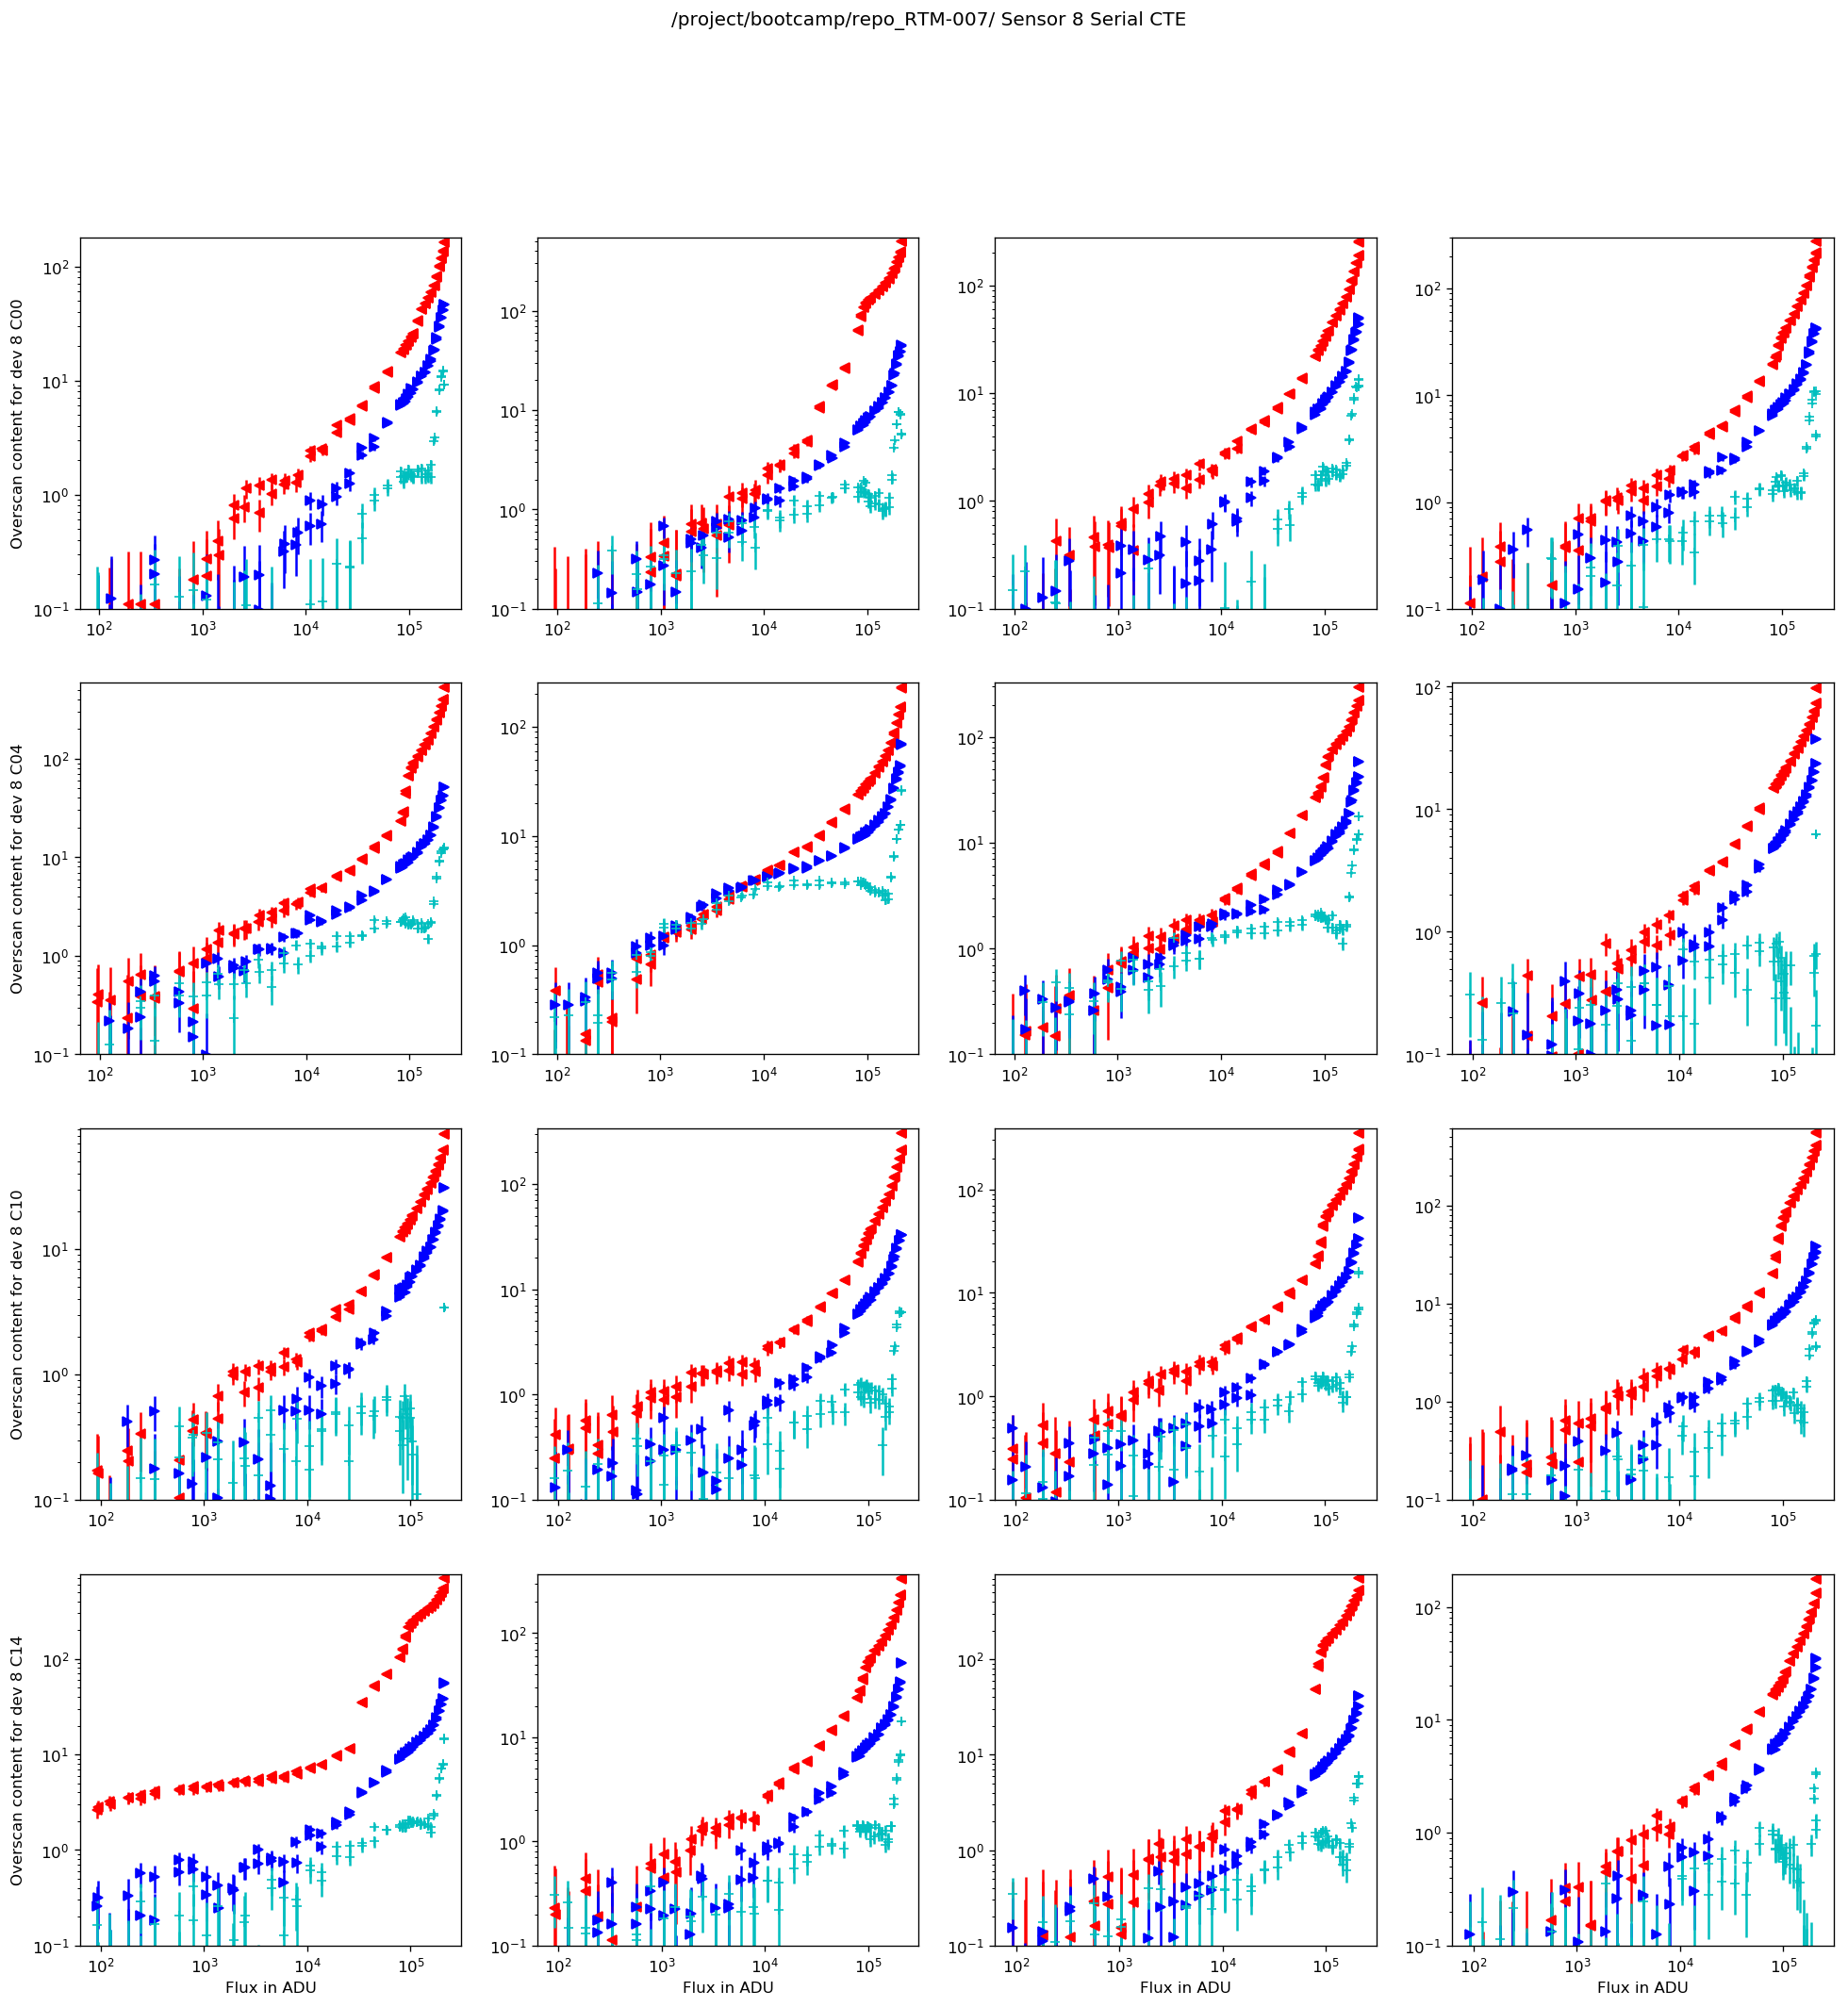

In [44]:
#
symb=['<','>','+']
col_symb=['r','b','c']
pix_name=['+1','+2','+3']
#
for det_id in range(0,9):
    fig=plt.figure(figsize=(20,20))
    label='%s Sensor %d Serial CTE' % (BOOTCAMP_REPO_DIR,det_id)
    fig.suptitle(label)
    iplt=0
    for key in flipXY:
        iplt+=1
        ax=fig.add_subplot(4,4,iplt)
        flux=np.zeros((len(visits)))
        pix=np.zeros((3,len(visits)))
        pix_std=np.zeros((3,len(visits)))
        for i,visit in enumerate(visits) :
            fcur=file[det_id][visit]
            flux[i]=fcur[key]['median_flux']
            #  pixel overscan content 
            for j in range(3) :
                pix[j,i]=(fcur[key]['serial'][j]) 
                pix_std[j,i]=fcur[key]['serial_std'][j] 
        for j in range(3) :
            plt.errorbar(flux,pix[j,:],yerr=pix_std[j,i],fmt=symb[j],color=col_symb[j], ecolor=col_symb[j],label=pix_name[j])
        plt.xscale('symlog')
        plt.yscale('log')
        plt.ylim(1e-1,max(np.max(pix)*1.1,10))
        if iplt%4 ==1 :
            label= 'Overscan content for dev %d %s' % (det_id,key)
            plt.ylabel(label)
        if iplt>12 :
            plt.xlabel('Flux in ADU')
    plt.show()    

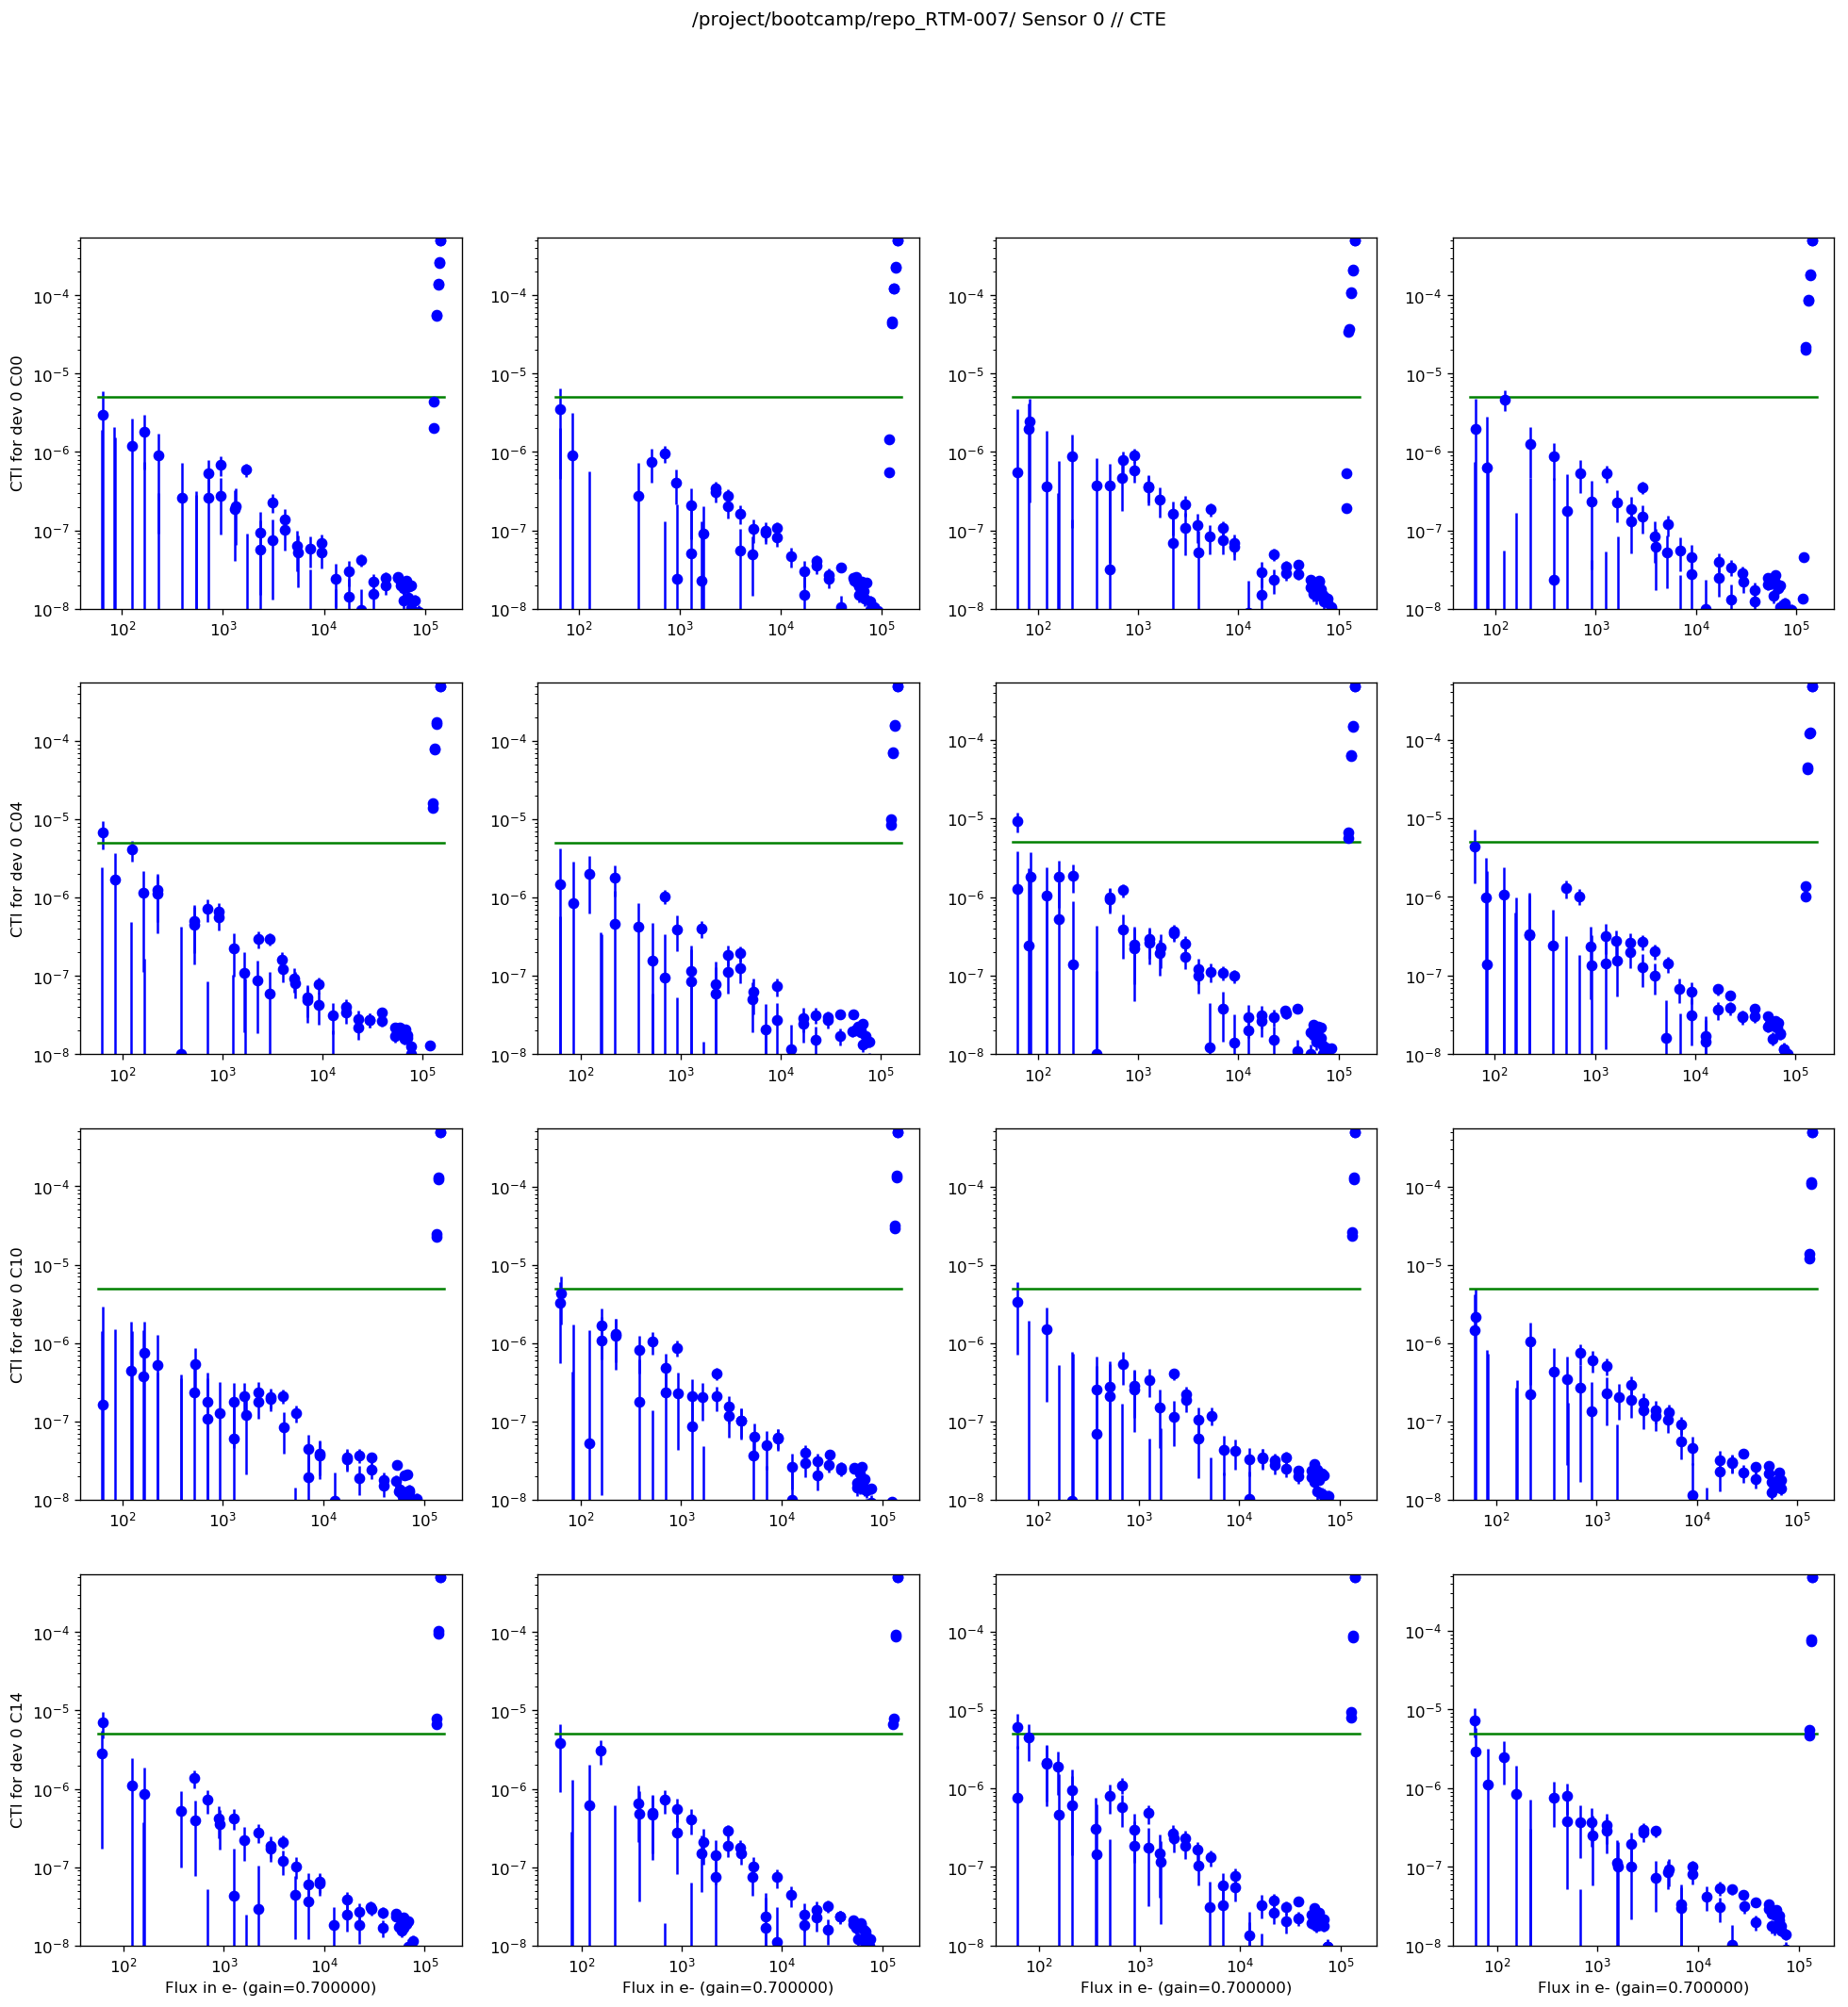

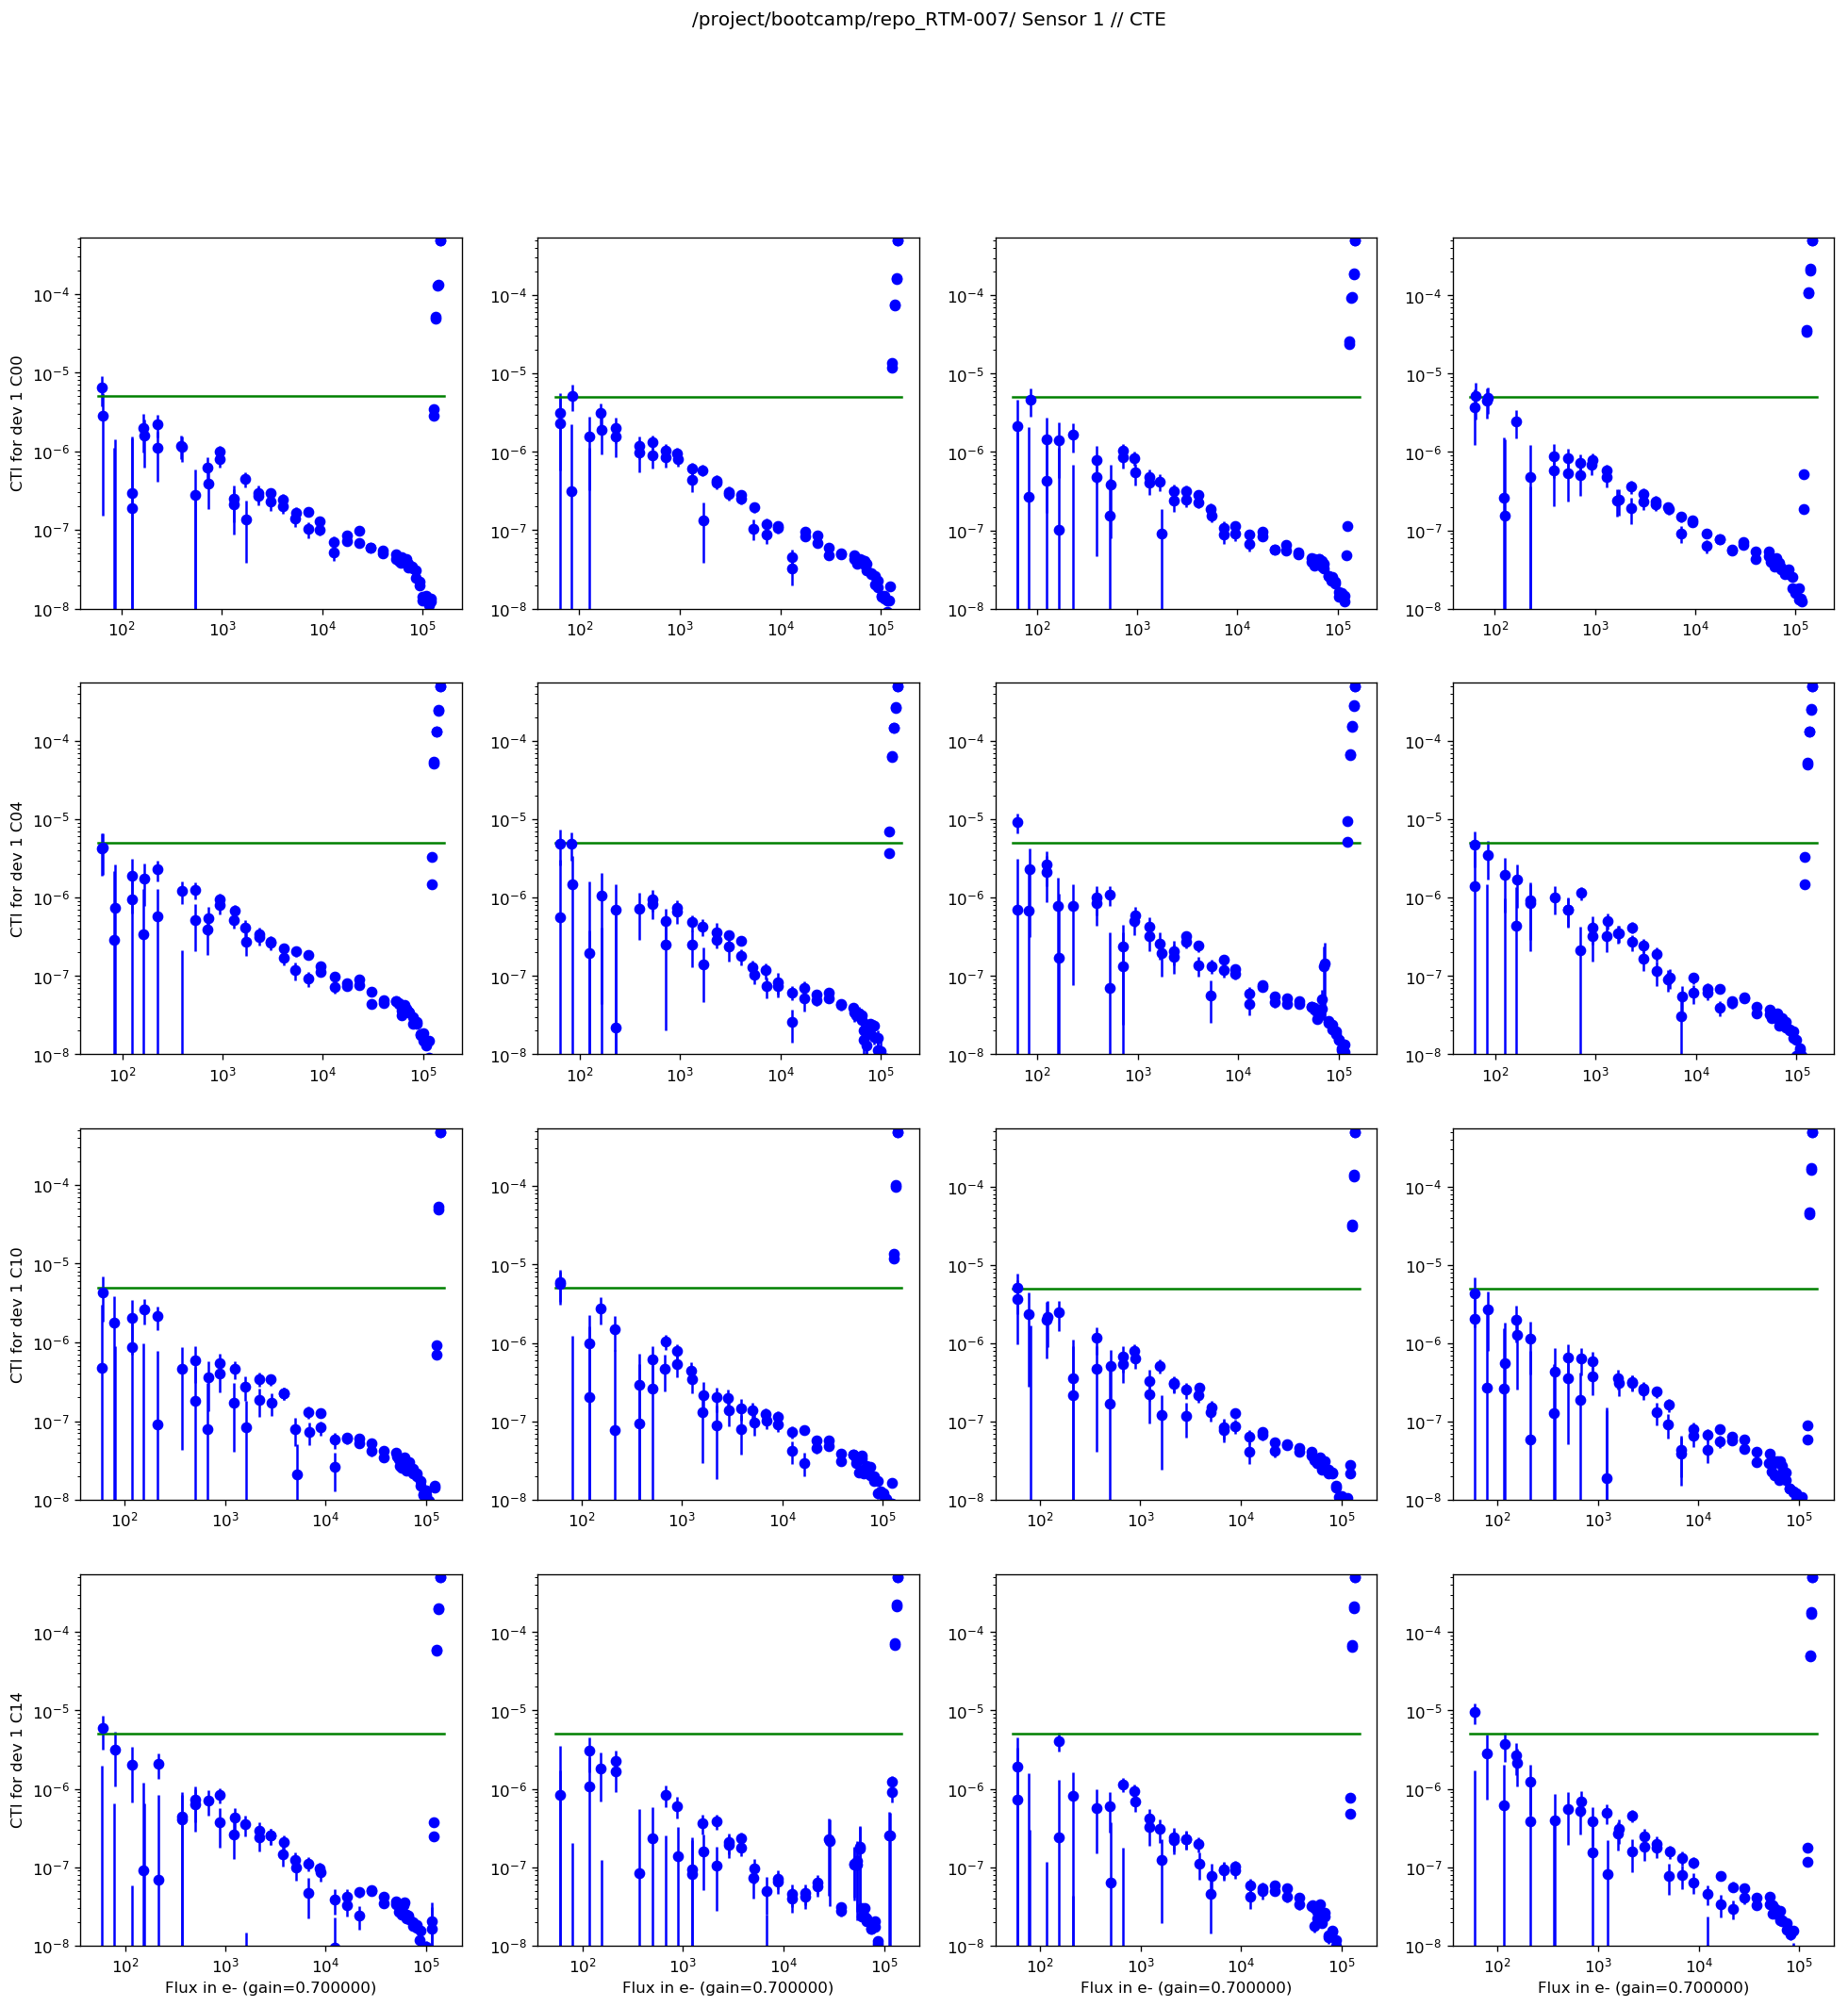

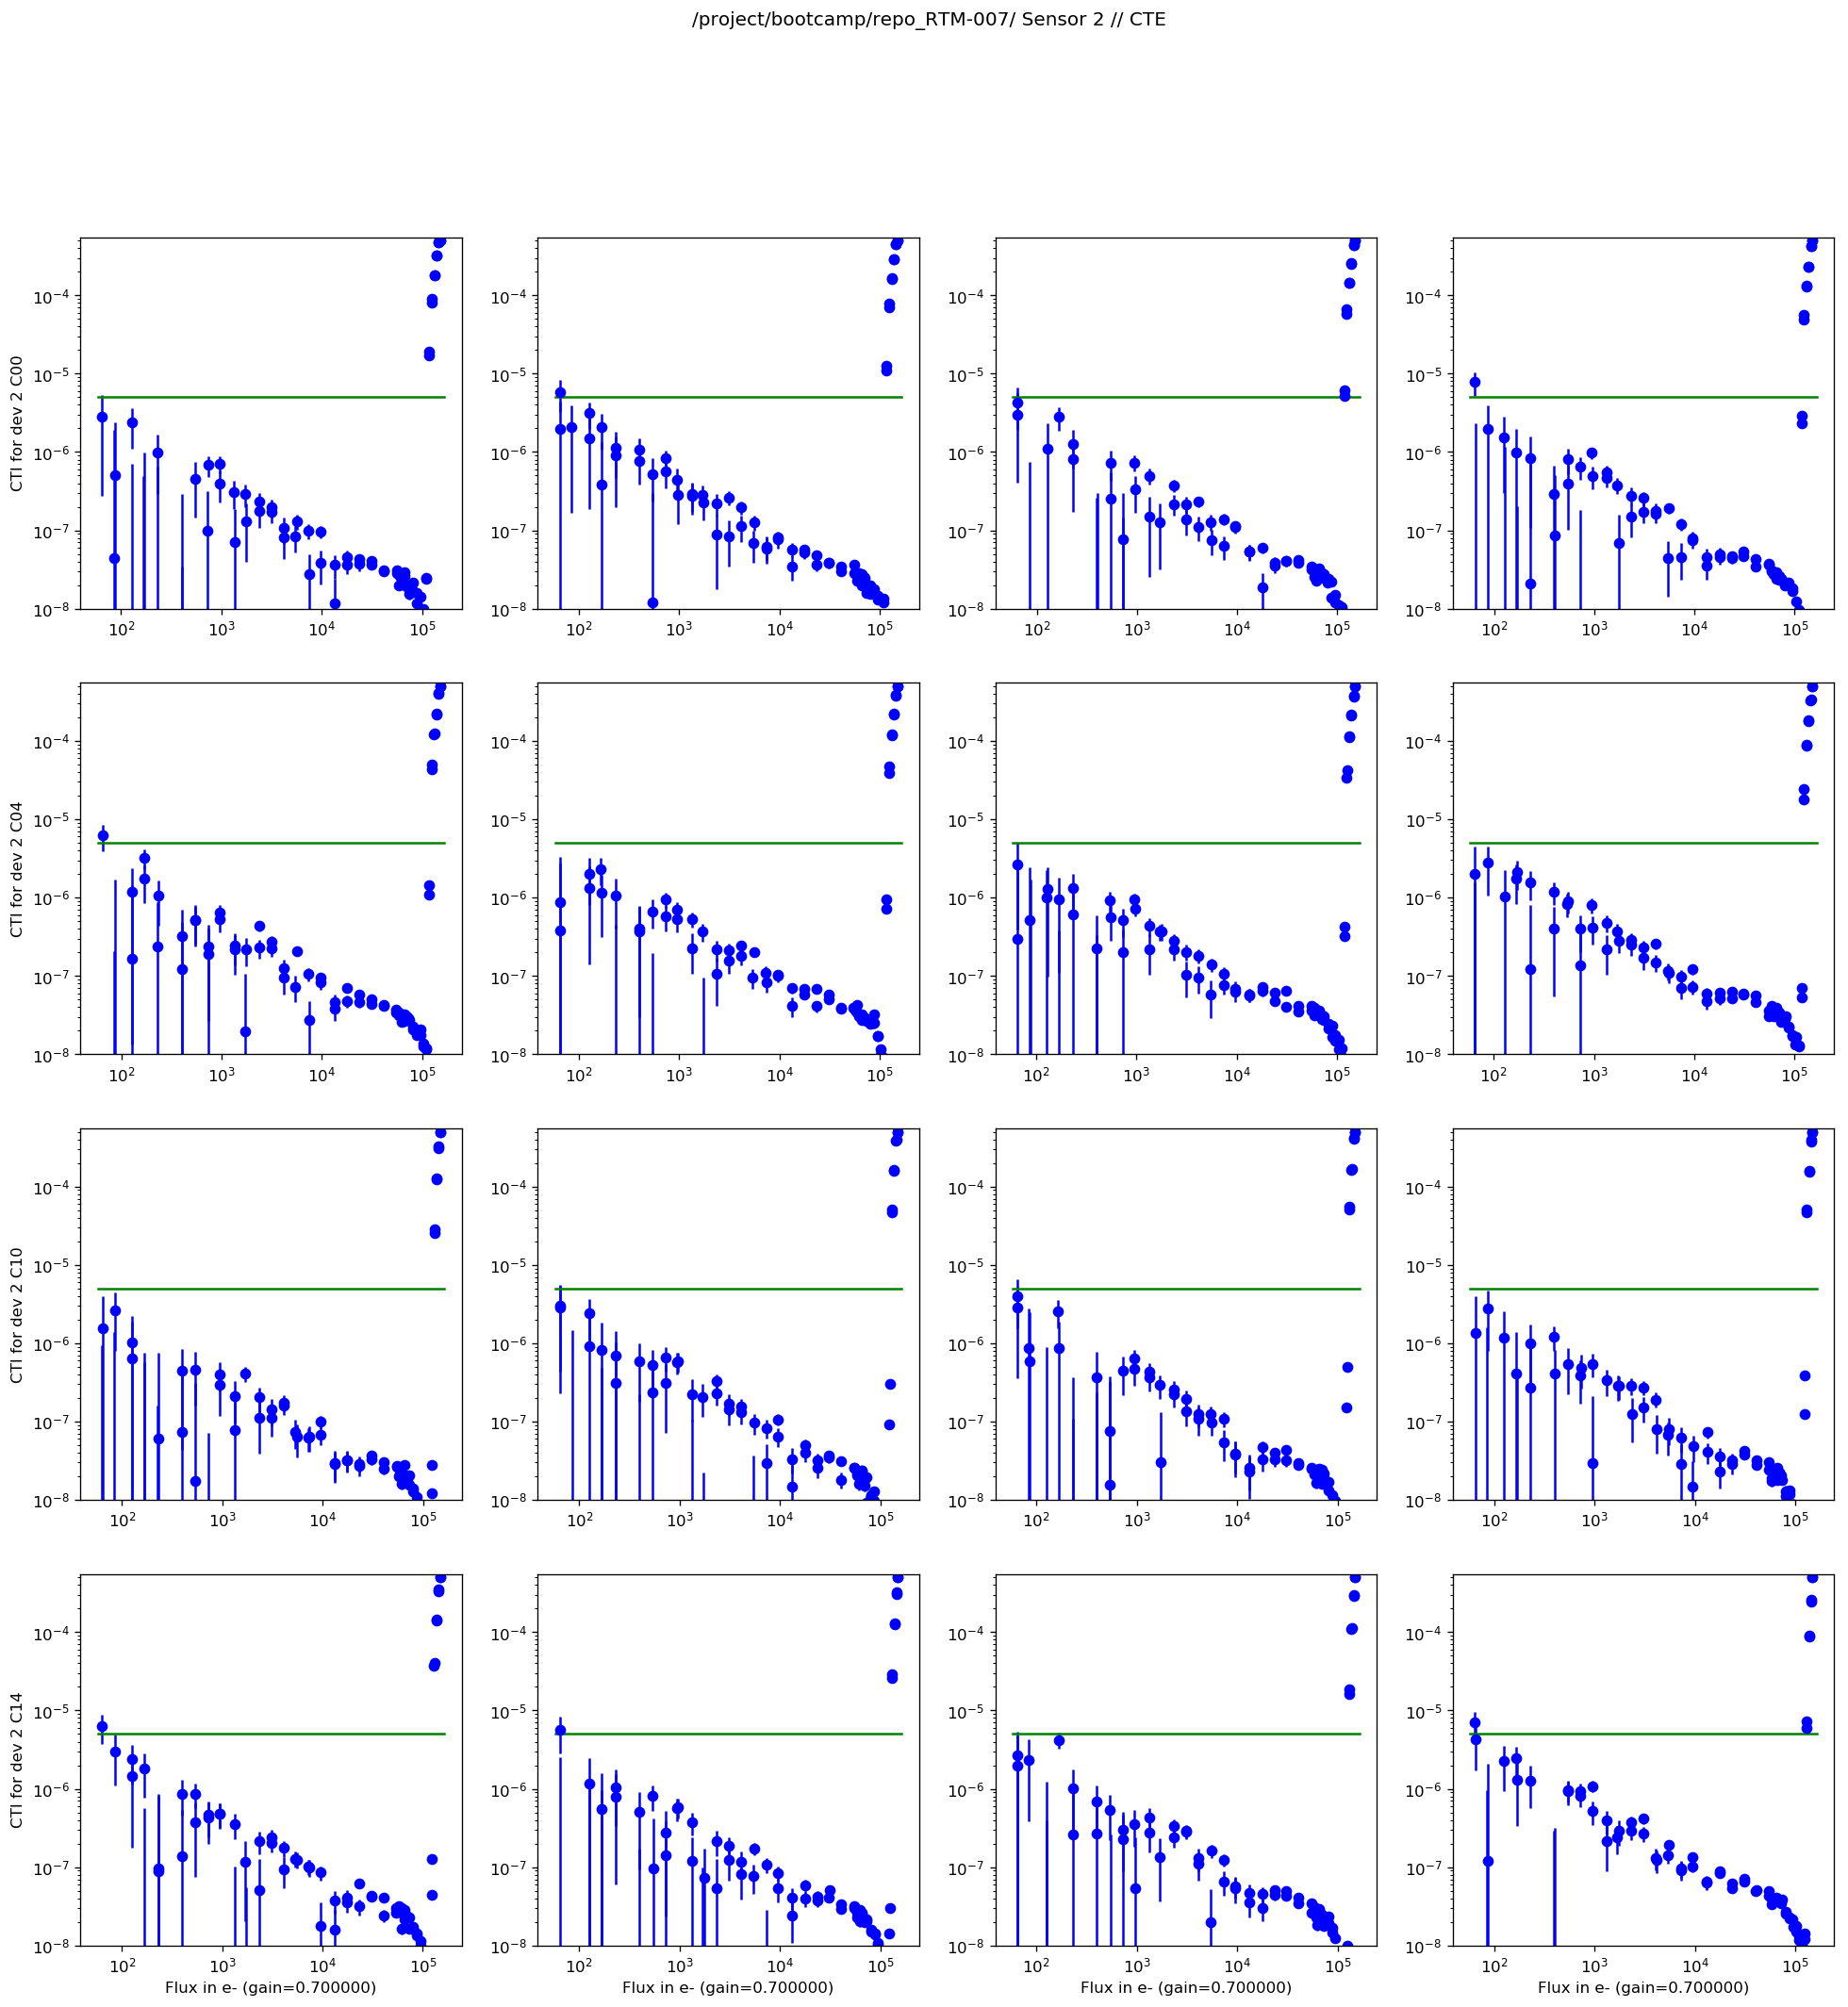

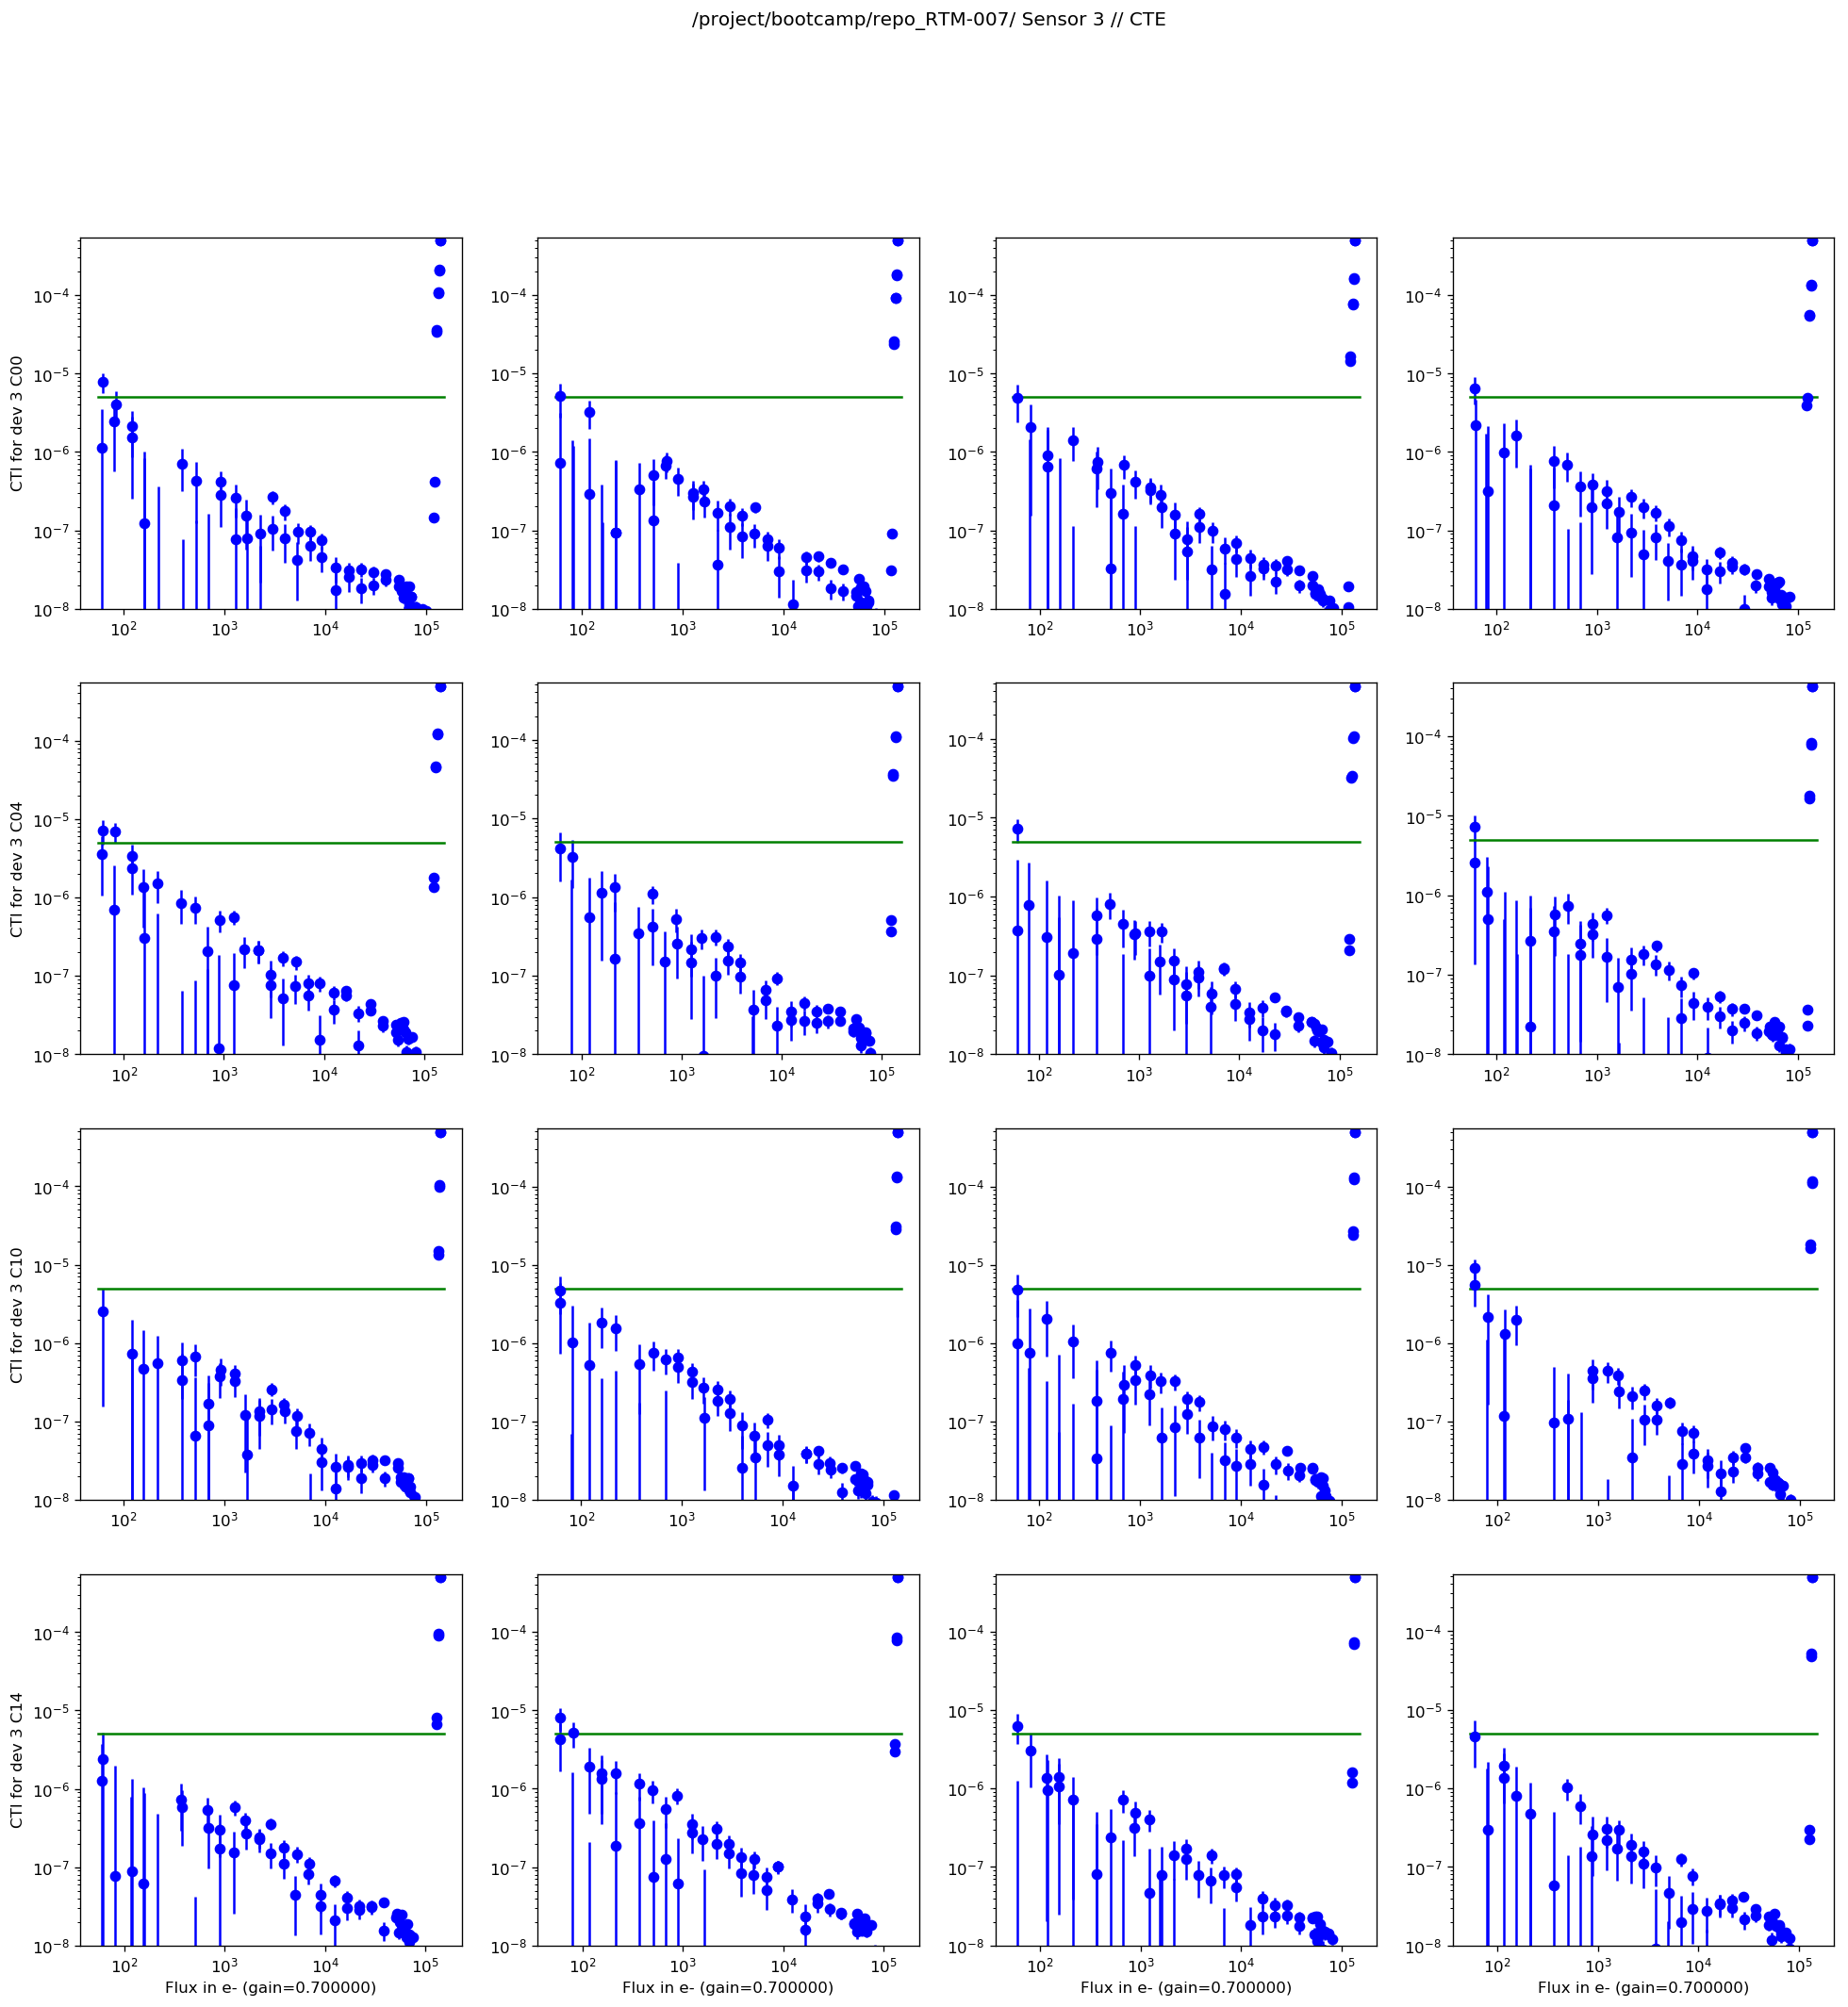

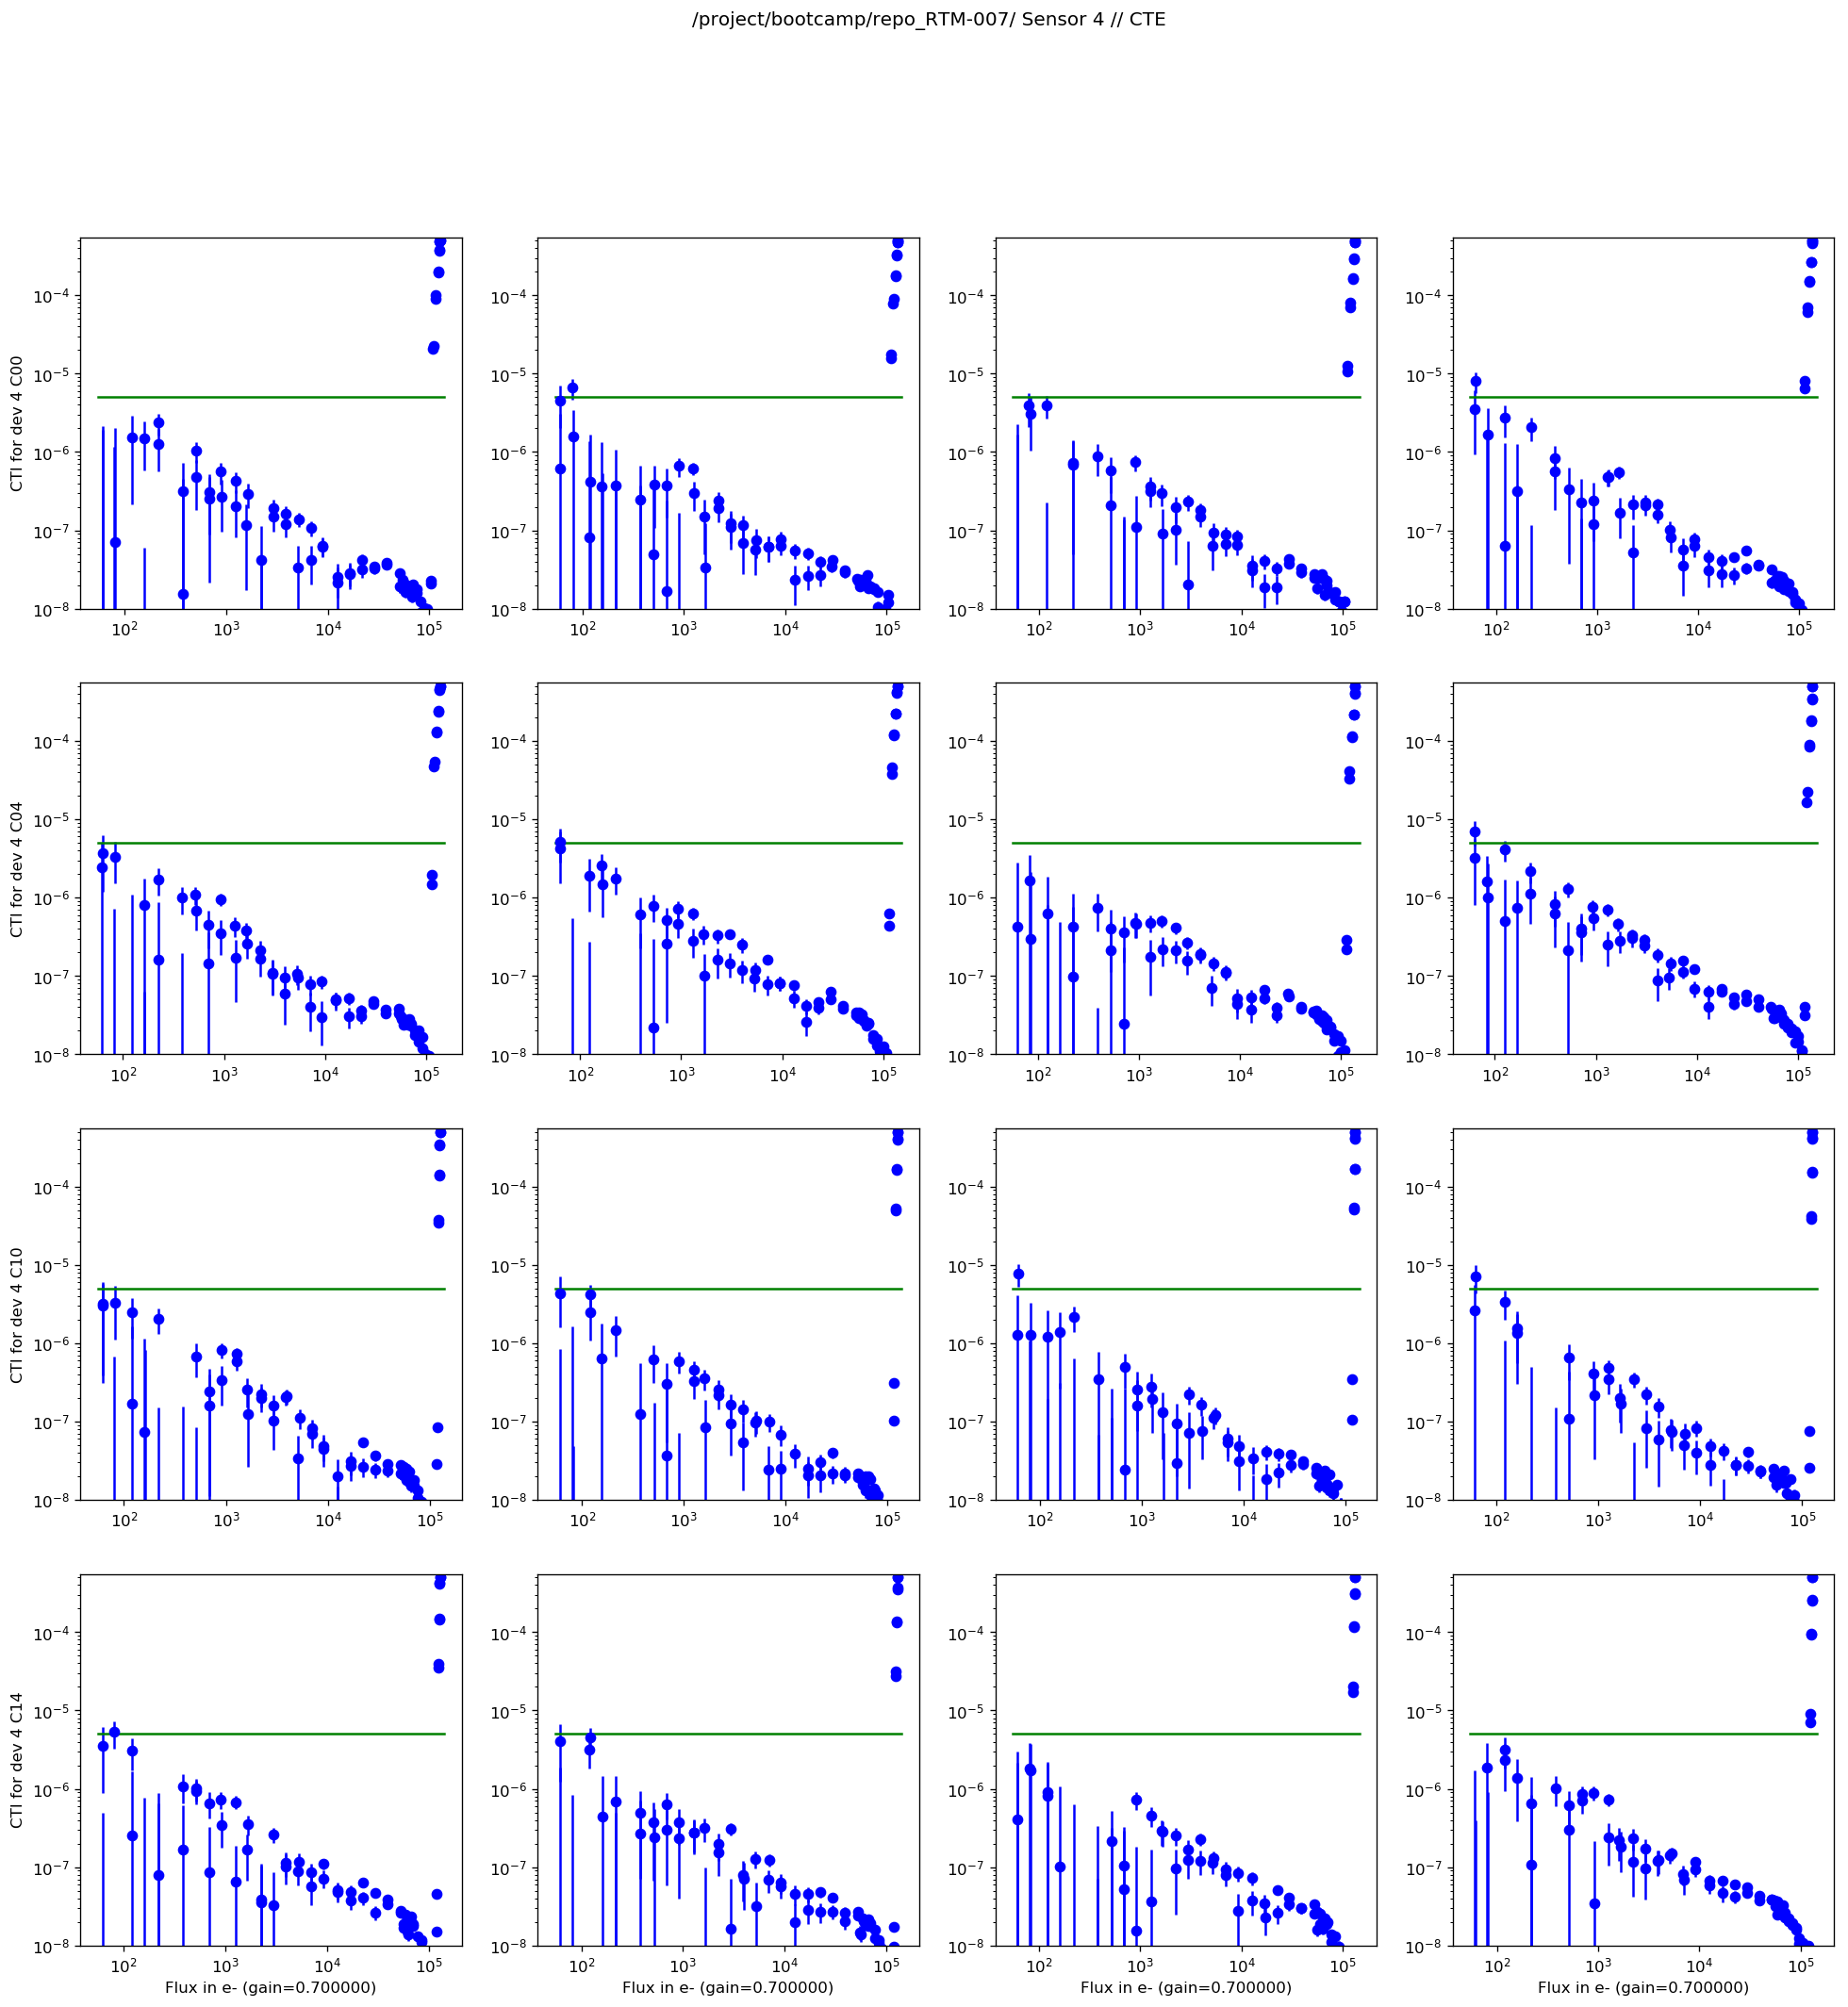

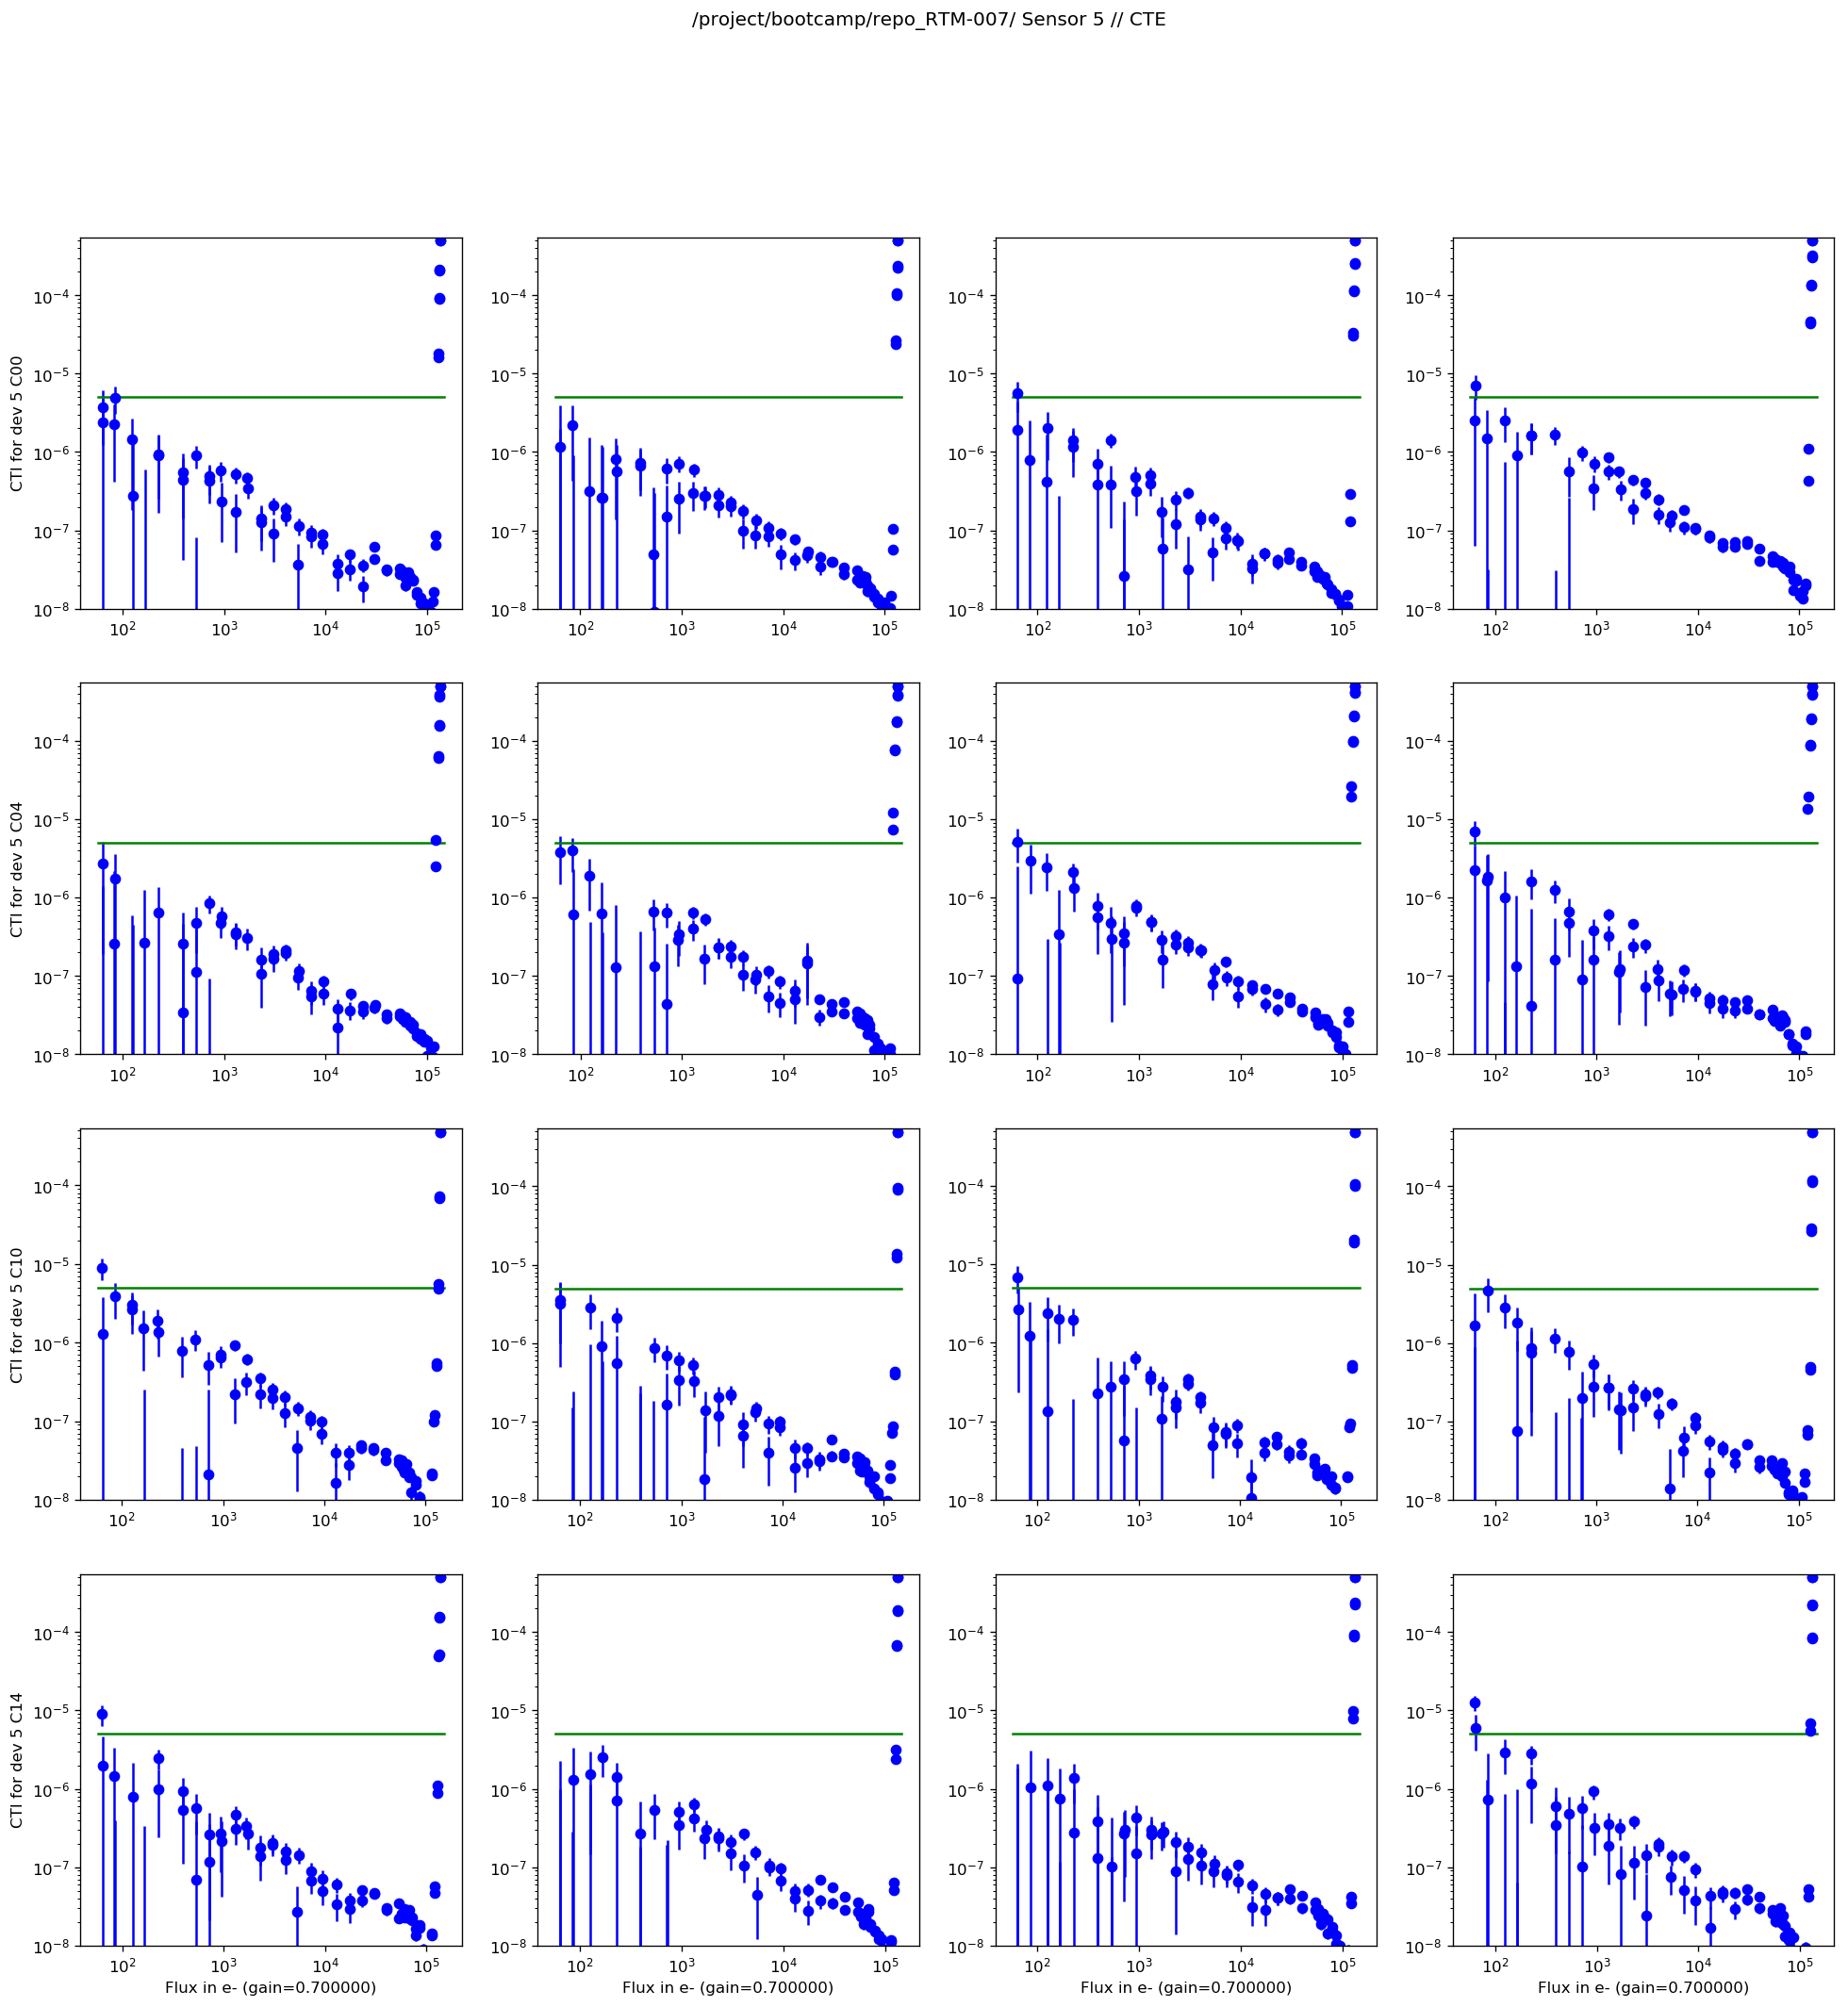

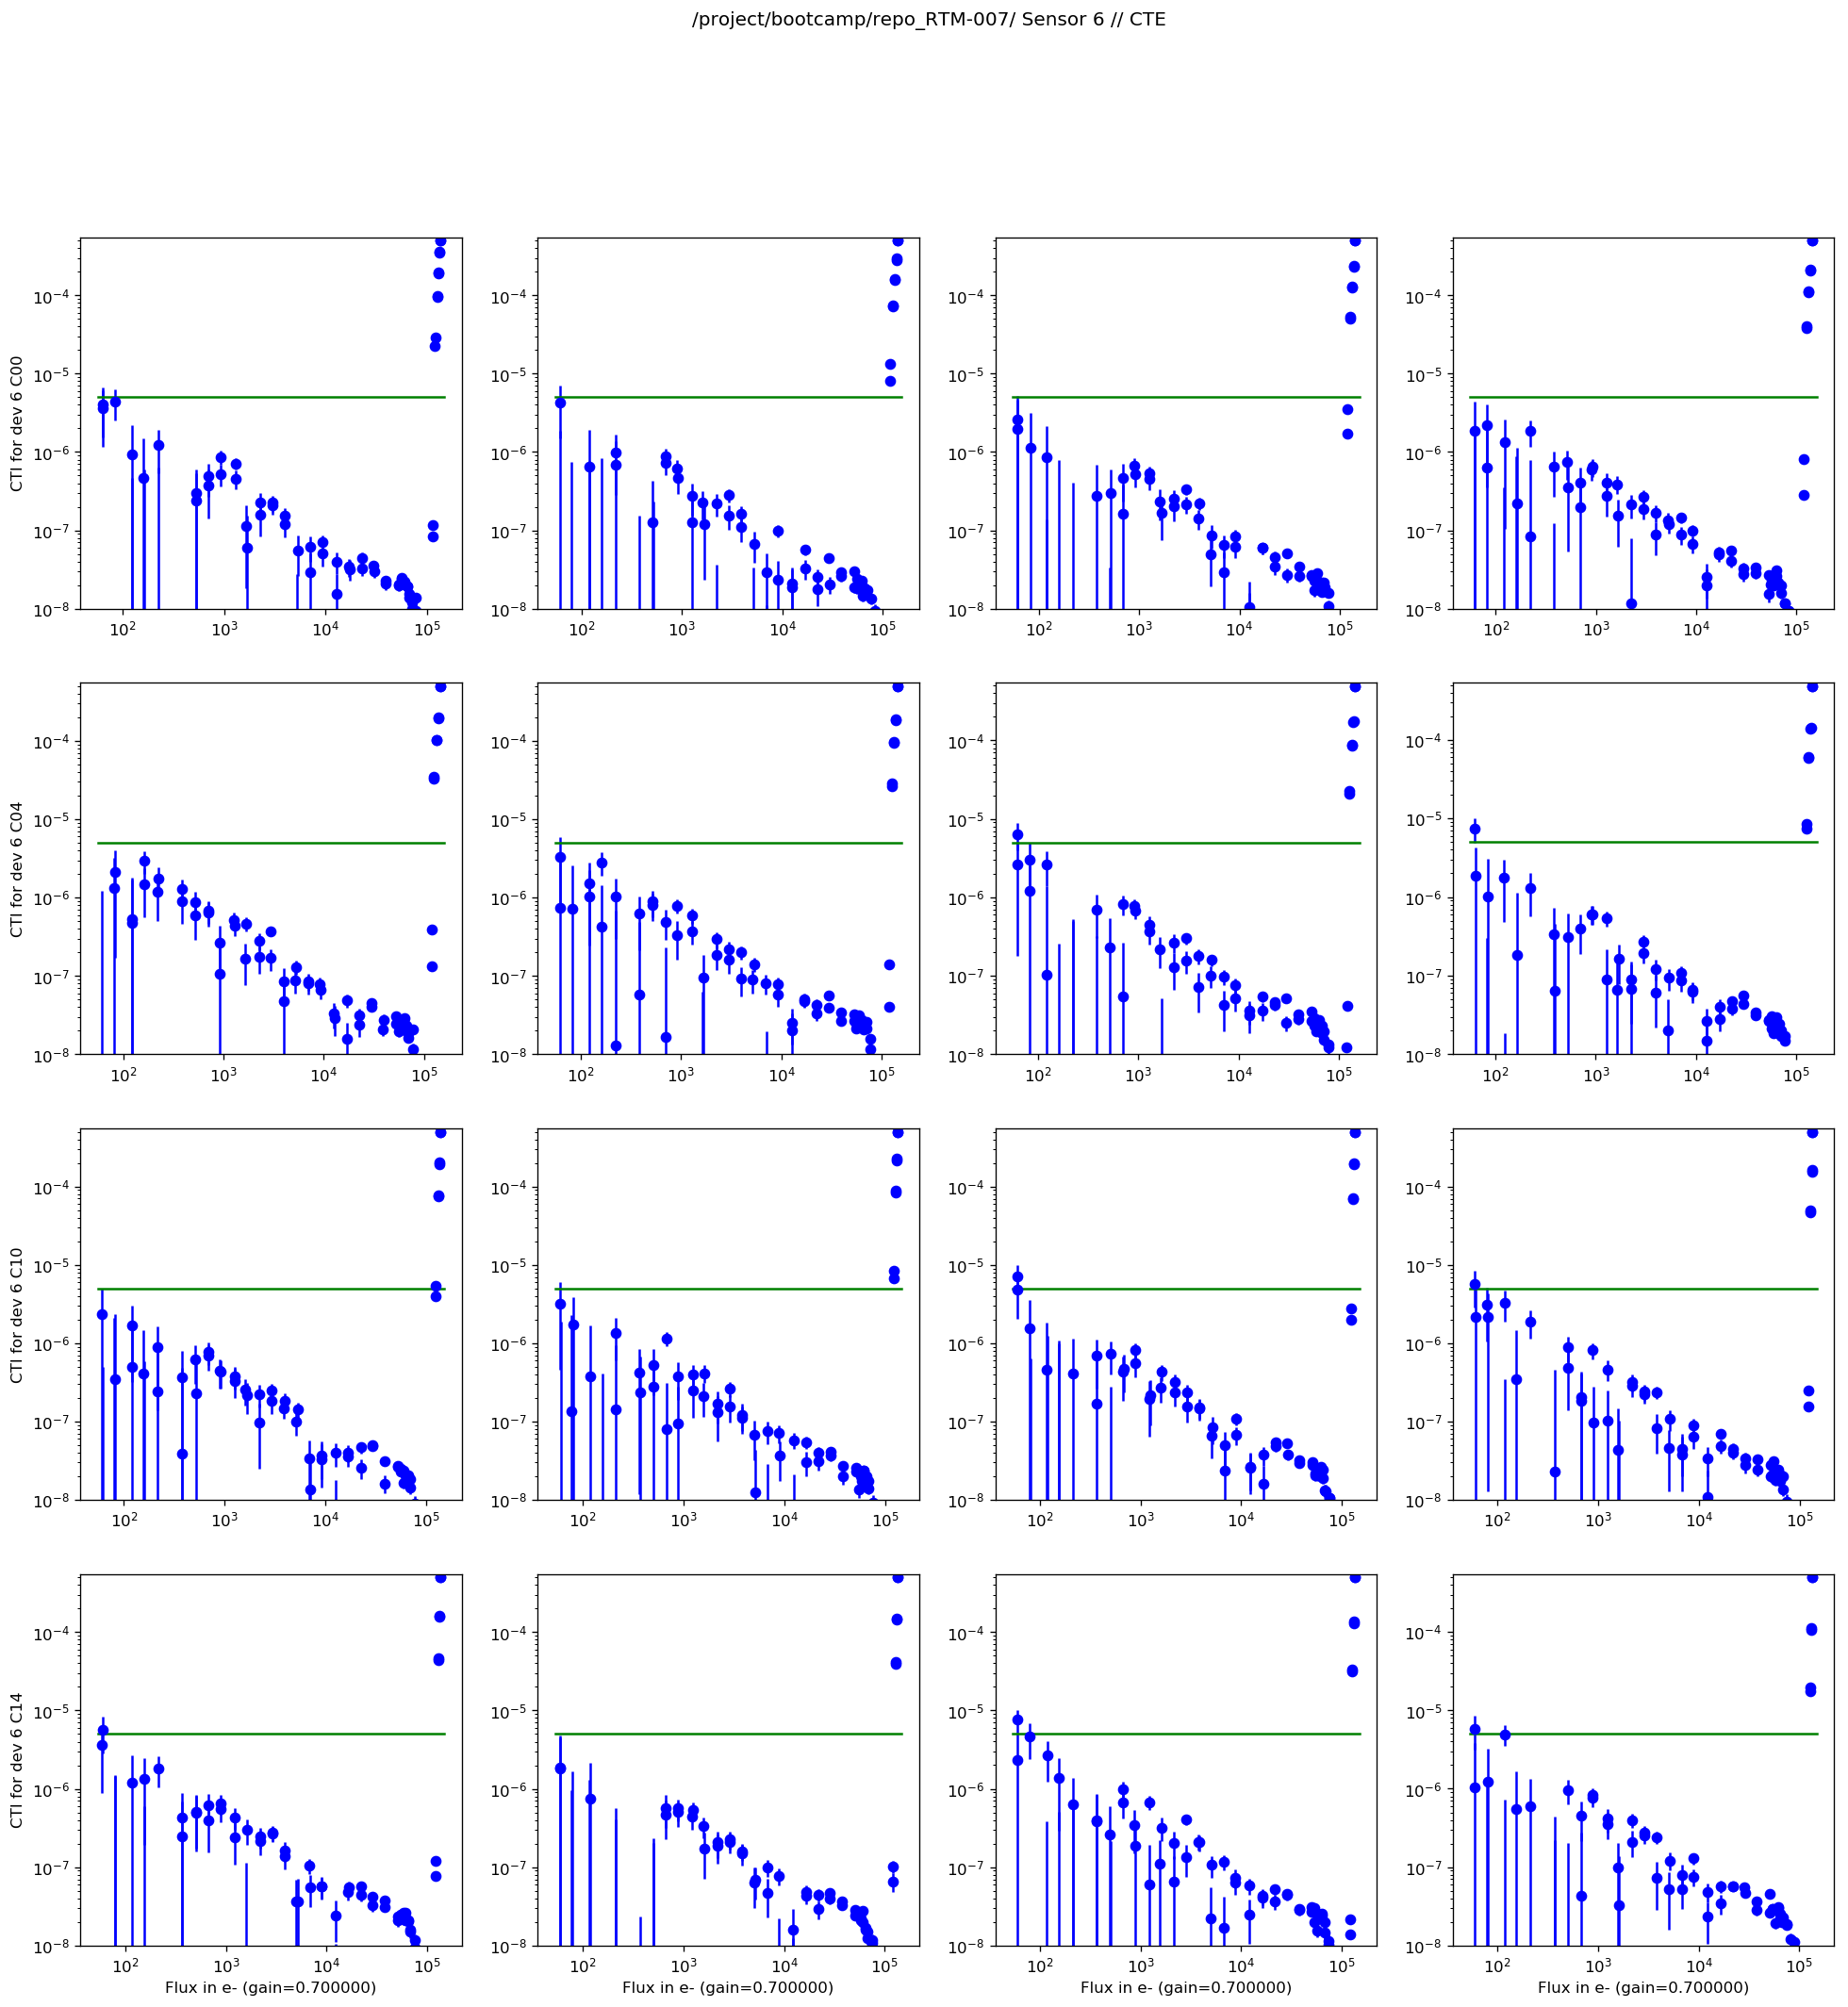

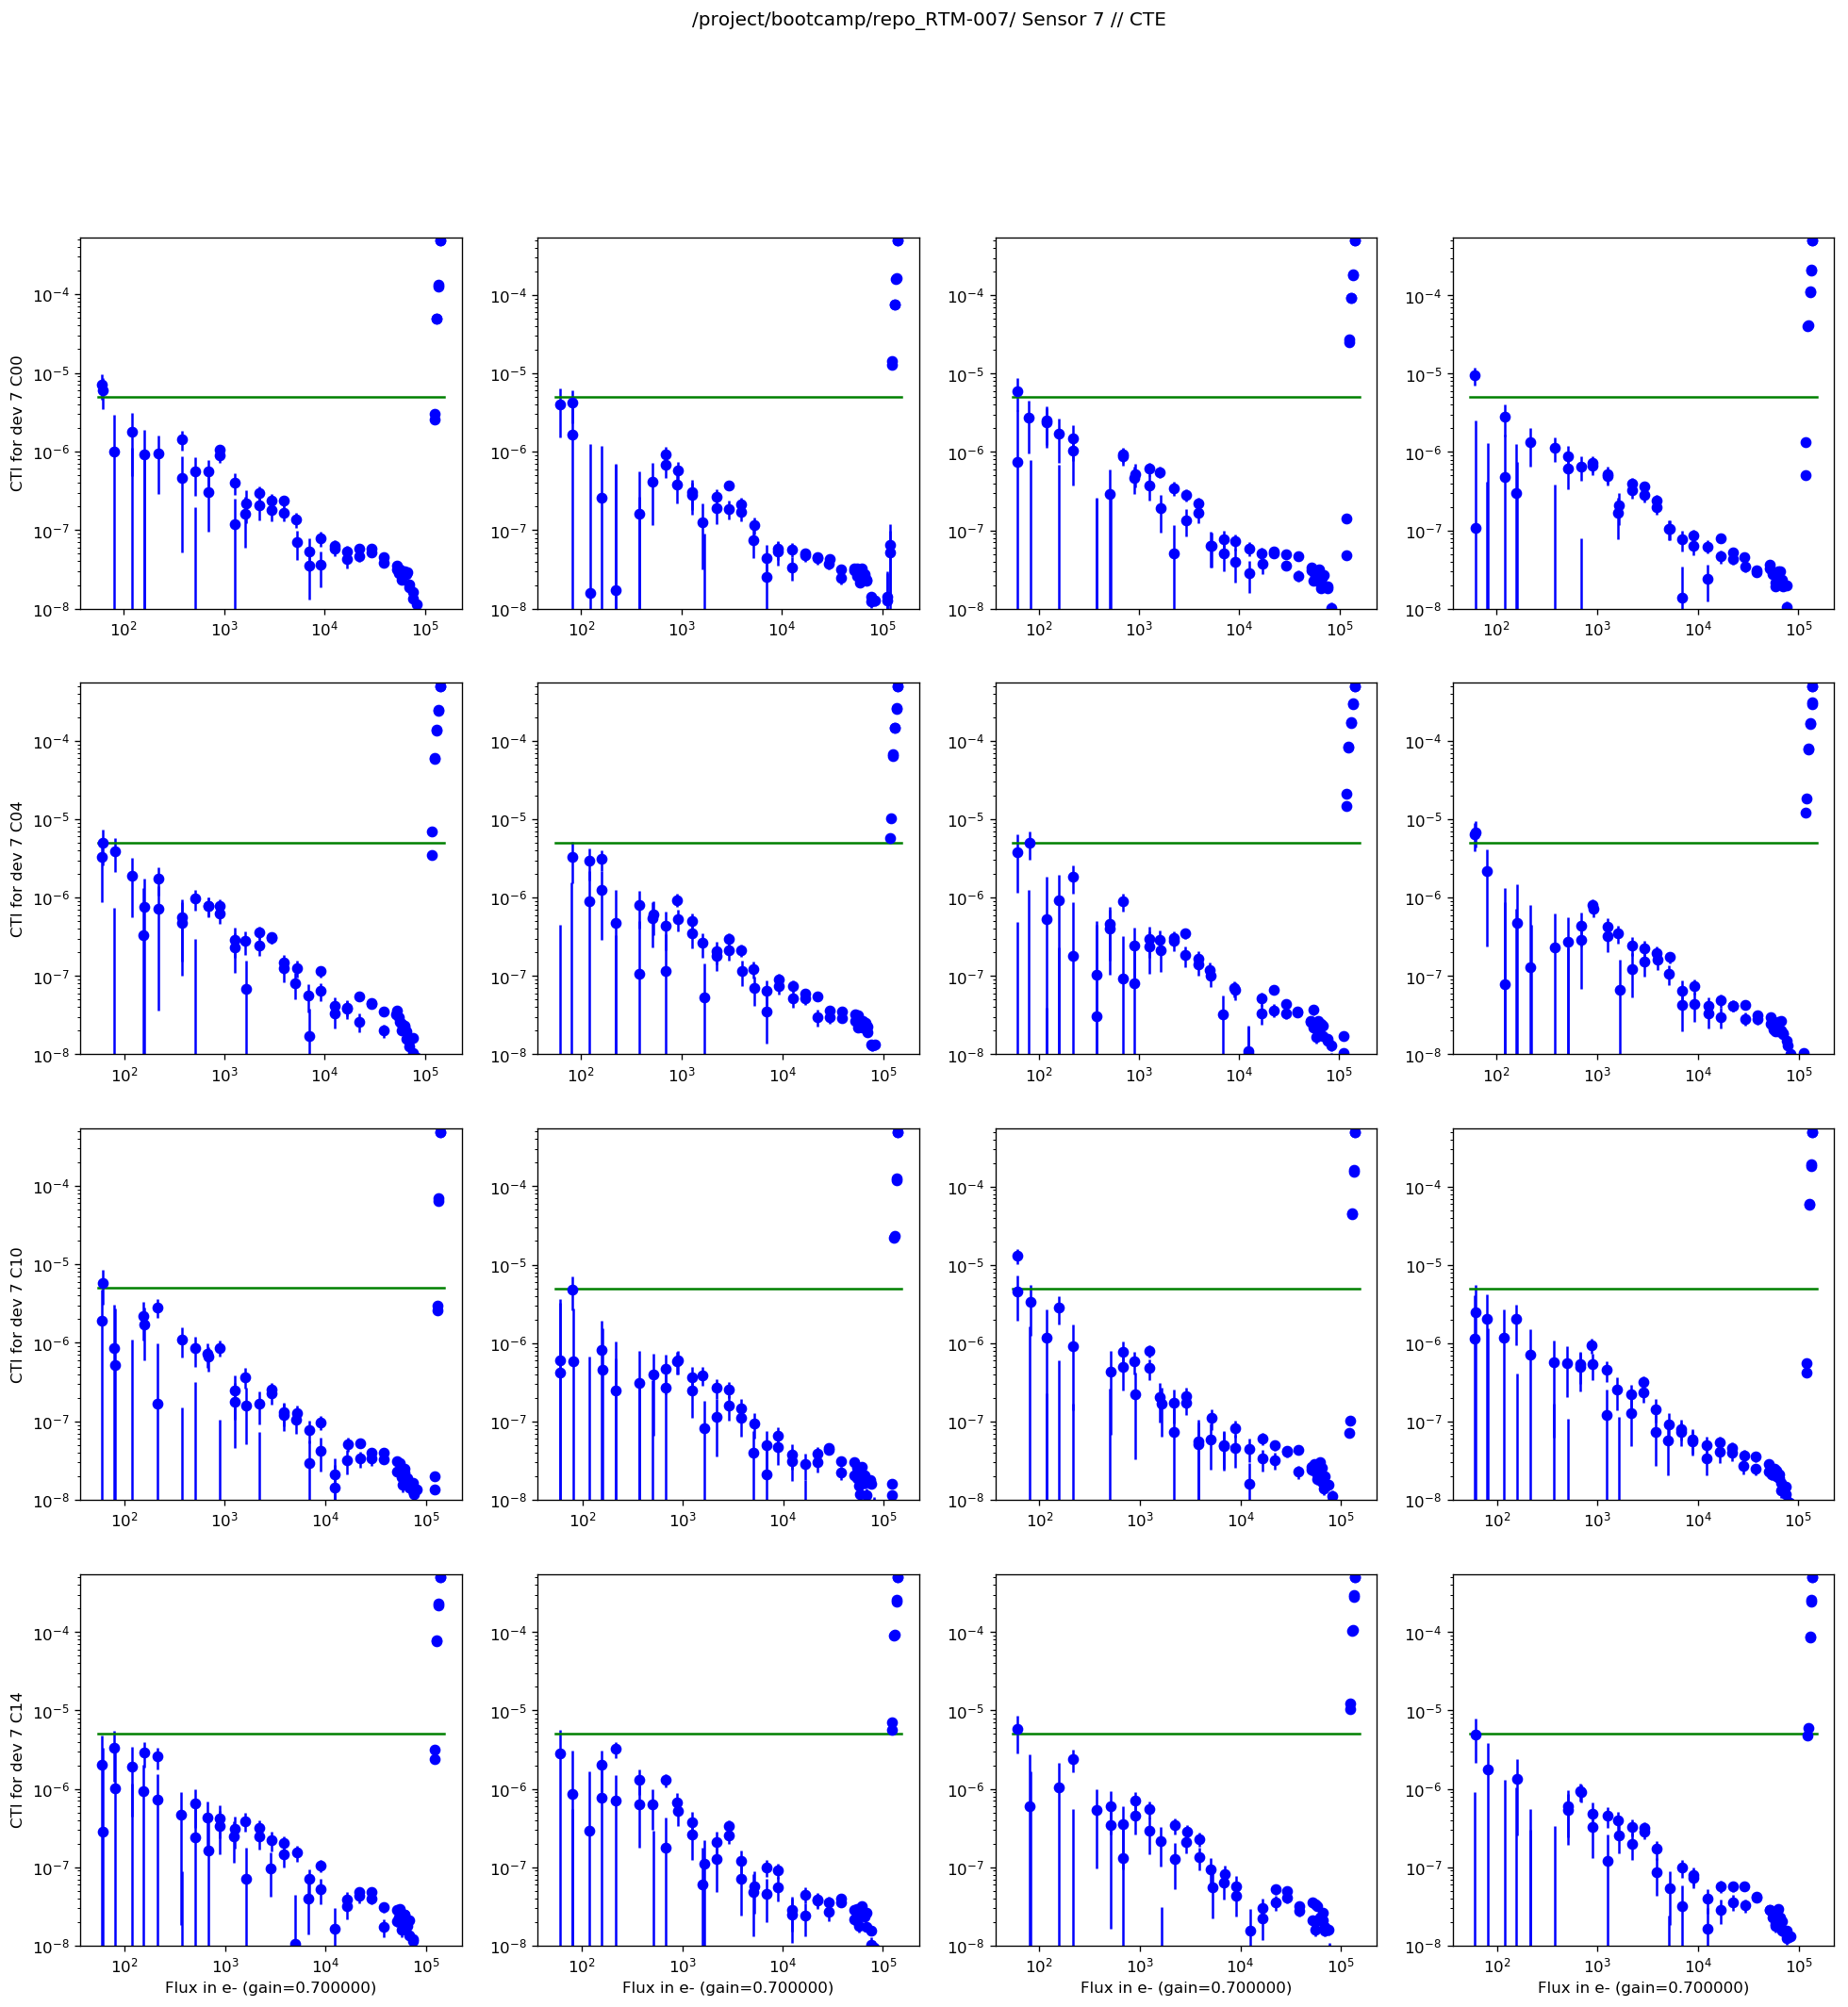

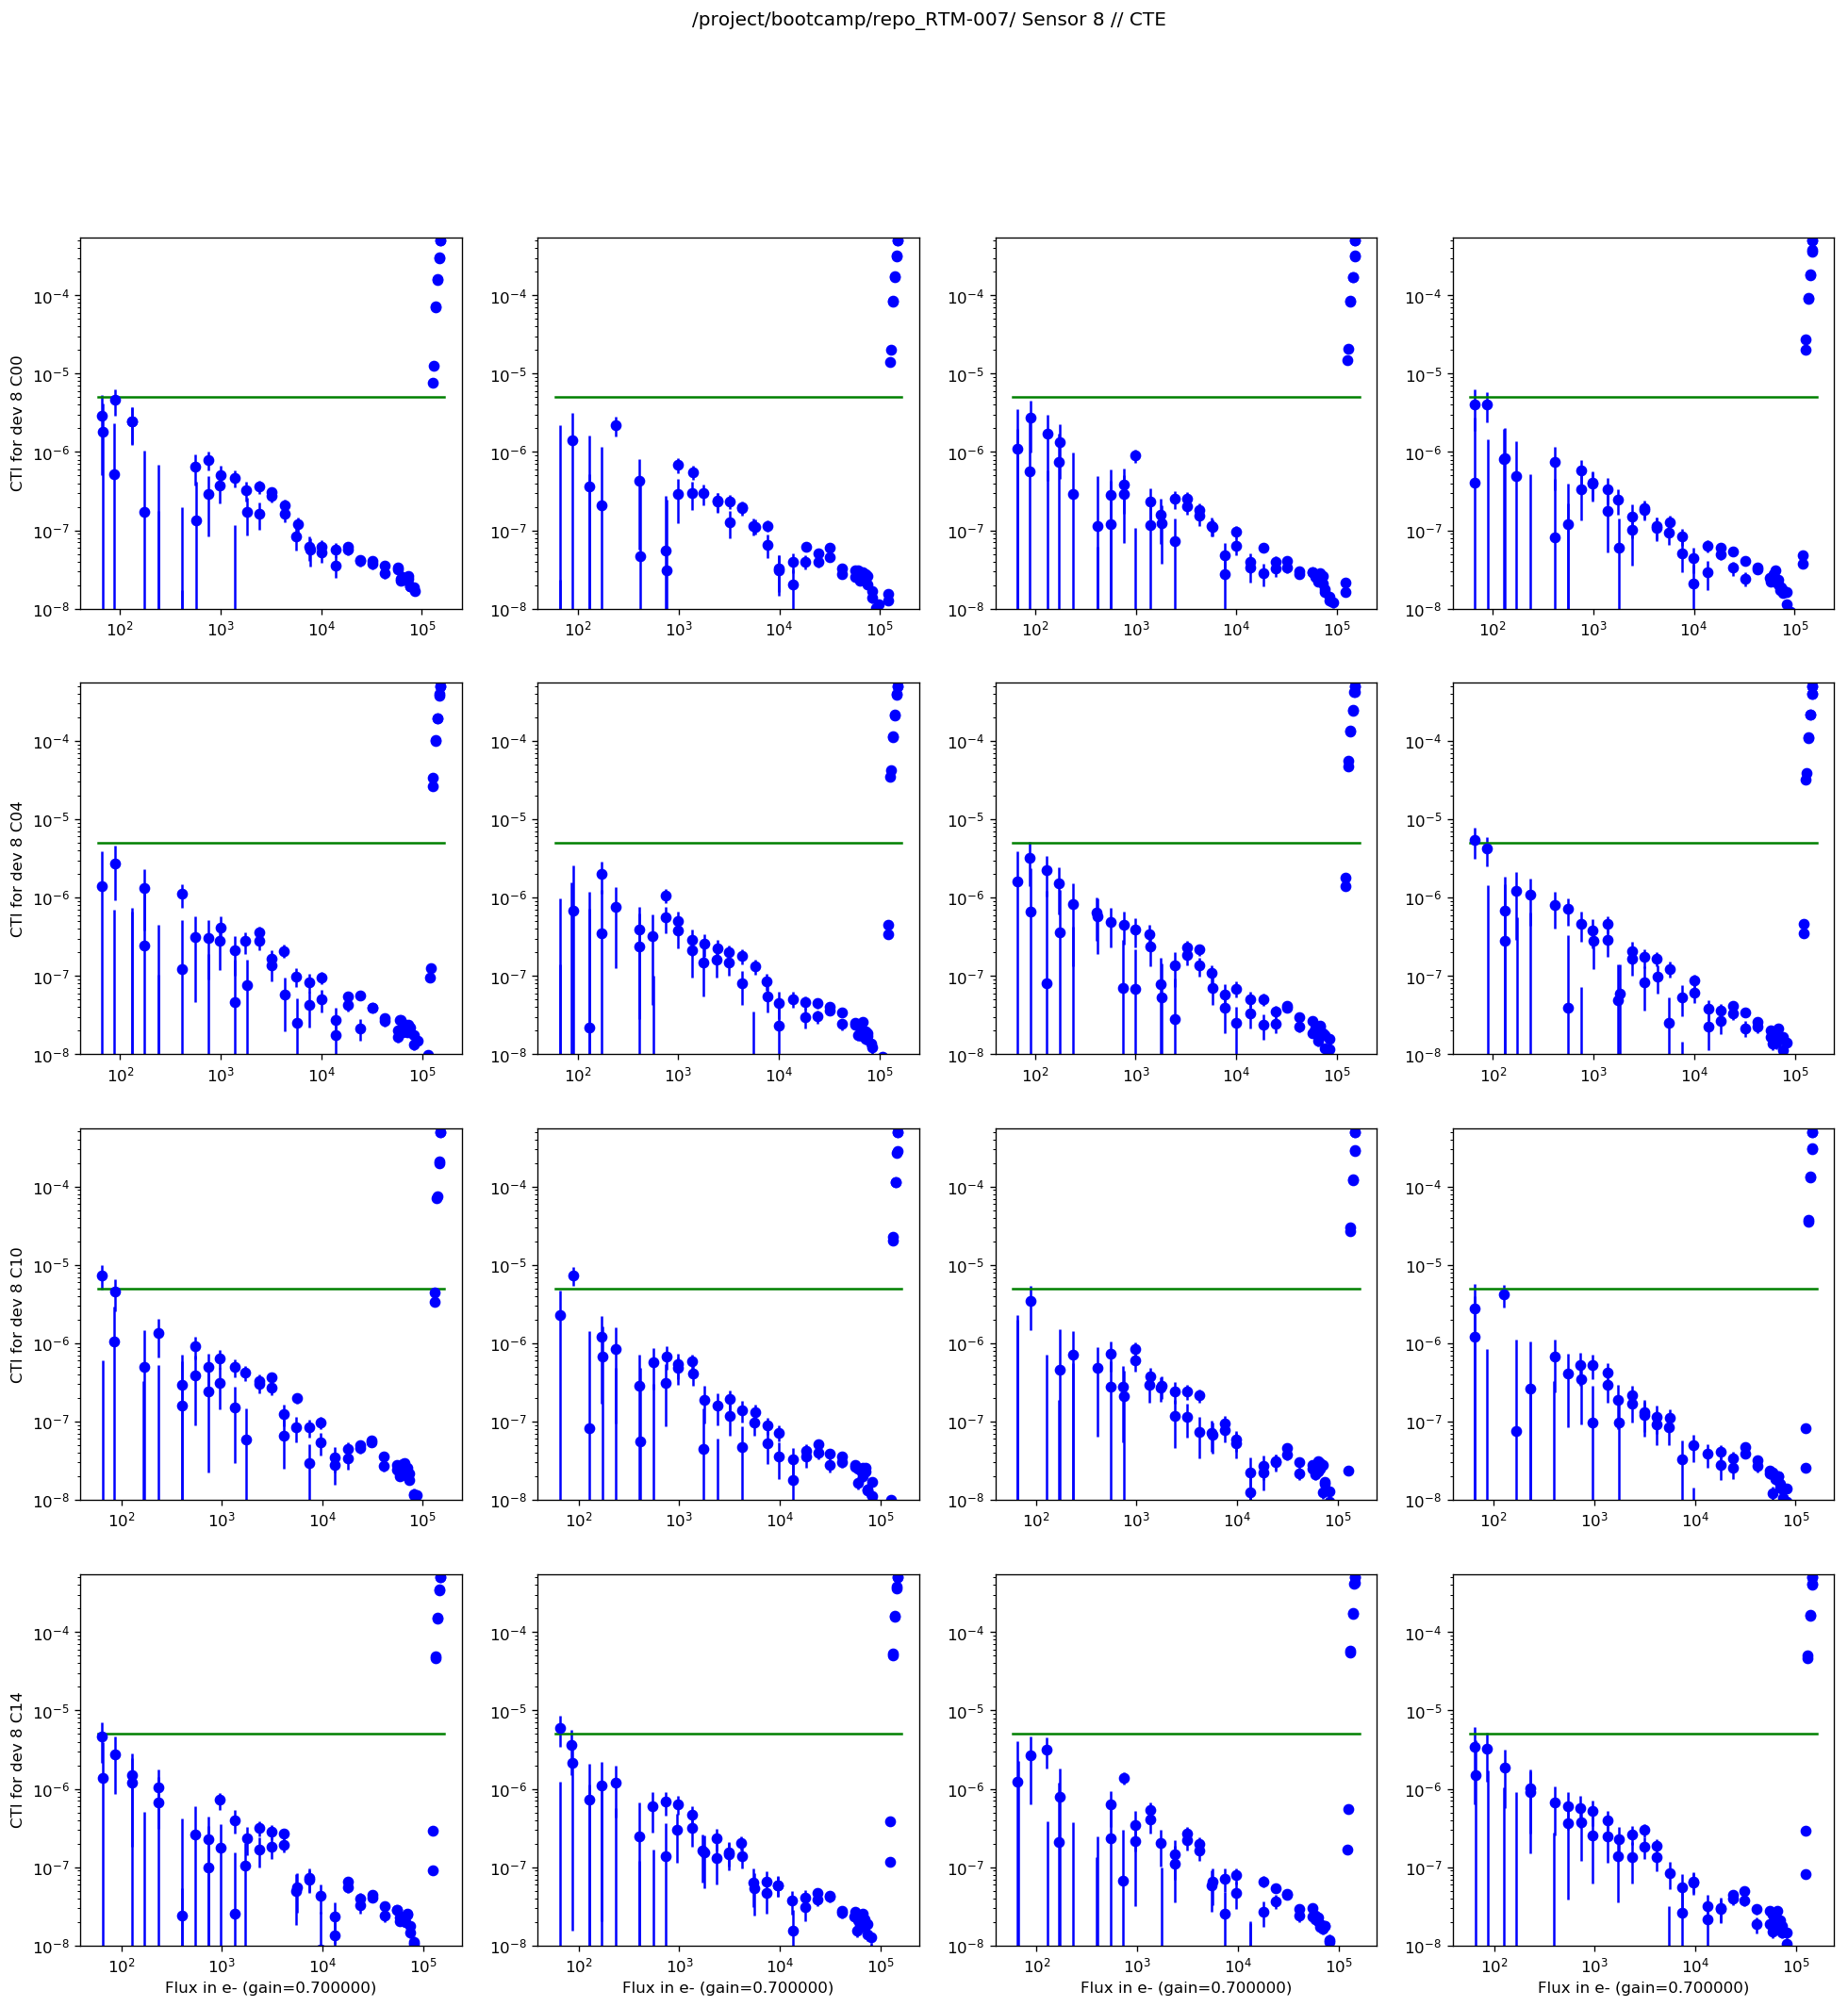

In [36]:
nb_par_shift=detector['C01'].getRawBBox().getDimensions().getY()-detector['C01'].getRawVerticalOverscanBBox().getDimensions().getY()
y_good=5e-6
gain=.7
for det_id in range(0,9):
    fig=plt.figure(figsize=(20,20))
    label='%s Sensor %d // CTE' % (BOOTCAMP_REPO_DIR,det_id)
    fig.suptitle(label)
    iplt=0
    for key in flipXY:
        iplt+=1
        ax=fig.add_subplot(4,4,iplt)
        flux=np.zeros((len(visits)))
        cti=np.zeros((len(visits)))
        cti_std=np.zeros((len(visits)))
        for i,visit in enumerate(visits) :
            fcur=file[det_id][visit]
            flux[i]=fcur[key]['median_flux']*gain
            cti[i]=fcur[key]['par'][0]/fcur[key]['last_line']/nb_par_shift  
            cti_std[i]=fcur[key]['par_std'][0]/fcur[key]['last_line']/nb_par_shift  
        plt.errorbar(flux,cti,yerr=cti_std,fmt='o',color='b', ecolor='b',label=key)
        xmin=min(flux)*.9
        xmax=max(flux)*1.1
        plt.plot([xmin,xmax],[y_good,y_good],'g')
        plt.xscale('symlog')
        plt.yscale('log')
        plt.ylim(1e-8,max(max(cti),y_good)*1.1)
        if iplt%4 ==1 :
            label= 'CTI for dev %d %s' % (det_id,key)
            plt.ylabel(label)
        if iplt>12 :
            label='Flux in e- (gain=%f)' %(gain)
            plt.xlabel(label)
    plt.show()    